In [1]:
using PyPlot, Printf, DelimitedFiles, JuliennedArrays, JLD2, Pipe

In [2]:
include("decode.jl")
include("utils.jl")

include("UpdateRule.jl")
include("Leaky.jl")
include("VarSMiLe.jl")
include("ParticleFiltering.jl")

include("inference.jl")
include("readData.jl")
include("regression.jl");

In [3]:
using MATLAB

function initMatlab()
    spmpath = "C:\\Users\\antho\\Documents\\MATLAB\\spm12"
    mat"""addpath($spmpath)"""
end

function BMS(lme; alpha0 = nothing)
    if alpha0 == nothing
        alpha0 = ones(1, size(lme,2))
    end
    mat"""[$alpha, $exp_r, $xp, $pxp, $bor] = spm_BMS($lme, 1e6, 0, 0, 1, $alpha0)"""
    return alpha, exp_r, xp, pxp, bor
end

initMatlab()
;

In [4]:
function saveRSS(RSS, subjectidx, models, slices, onehotencode_blocks, normalize_meg, N, dir = "rss")
    !isdir(dir) && mkdir(dir)
    
    meta_filename = "$dir/meta.jld2"
    if !isfile(meta_filename)
        meta = Dict(
            "models"              => models,
            "slices"              => slices,
            "onehotencode_blocks" => onehotencode_blocks,
            "normalize_meg"       => normalize_meg
        )
        @save meta_filename meta
    end
    
    filename = "$dir/subject_$subjectidx.jld2"
    @save filename RSS N
end

function loadRSSMeta(dir = "rss")
    meta_filename = "$dir/meta.jld2"
    if !isfile(meta_filename)
        return nothing
    end
    
    @load meta_filename meta
    return meta
end

function loadRSS(subject, dir = "rss")    
    filename = "$dir/subject_$subject.jld2"
    if !isfile(filename)
        return nothing, 0
    end
    
    @load filename RSS N
    return RSS, N
end
;

In [5]:
function exportBIC(BIC, filename)
    f = matopen("ckpt/$filename", "w")
    write(f, "F", BIC)
    close(f)
end

function importBIC(filename)
    f = matopen("ckpt/$filename", "r")
    F = read(f, "F")
    close(f)
    
    return F
end
;

In [6]:
function computeRSS(X::Array{Float64,2}, y::Array{Float64,1})
    return deviance(fit(LinearModel, X, y))
end
function computeRSSByBlock(X::Array{Float64,2}, y::Array{Float64,1}, blocks = 4)
    rss = zeros(blocks)
    for block in 1:blocks
        xblock = X[X[:,block] .== 1,end]
        yblock = y[X[:,block] .== 1]
        rss[block] = deviance(fit(LinearModel, hcat(ones(length(xblock)), xblock), yblock))
    end
    return rss
end


function computeBIC(sigma2::Float64, n::Int, k = 6)
    return n * log(sigma2) + k * log(n)
end

function computeBIC(sigma2::Array{Float64,1}, n::Array{Int,1}, k = 6)
    return n .* log.(sigma2) .+ k * log.(n)
end
;

In [7]:
function mapsaveRSS(subject, subjectidx, models, slices,
        onehotencode_blocks = true, normalize_meg = false,
        dir = "rss", verbose = 2)
    
    # map trials to Shannon surprise
    ssh, megs = mapssh(subject, models, onehotencode_blocks, verbose)
    
    # log info
    verbose > 1 && lg("mapsaveRSS: computing RSS...")
    
    # regress for each slice
    N = size(megs, 1)
    RSS = Array{Array{Float64,3},2}(undef, length(slices), length(models))
    
    for slice in eachindex(slices)
                
        # normalize data
        meg = view(megs, :, :, slices[slice])
        if normalize_meg
            meg = (meg .- mean(meg, dims=1)) ./ std(meg, dims=1)
        end
        
        # regress for each model
        for model in eachindex(ssh)
            
            # regress for each sensor and timepoint
            r = zeros(length(ssh[model]), size(meg,2), size(meg,3))
            for i in 1:size(meg,2), j in 1:size(meg,3)
                r[:,i,j] = computeRSS.(ssh[model], Ref(meg[:,i,j]))
            end
            
            RSS[slice,model] = r
        end
    end
    
    # save RSS
    saveRSS(RSS, subjectidx, models, slices, onehotencode_blocks, normalize_meg, N, dir)
    
    return RSS, N
end
;

In [8]:
function mapRSS(subject, subjectidx, models, slices,
        onehotencode_blocks = true, normalize_meg = false,
        dir = "rss", verbose = 2)
    
    verbose > 1 && lg("mapRSS: Trying to load RSS")
    RSS, N = loadRSS(subjectidx, dir)
    
    if isnothing(RSS)
        verbose > 1 && lg("mapRSS: Computing RSS from scratch")
        return mapsaveRSS(subject, subjectidx, models, slices, 
            onehotencode_blocks, normalize_meg, dir, verbose)
    else
        verbose > 1 && lg("mapRSS: Reusing older RSS")
        return RSS, N
    end
end
;

In [9]:
function mapBIC(subject, subjectidx, models, slices,
        onehotencode_blocks = true, normalize_meg = false,
        dir = "rss", verbose = 2)
    
    if verbose > 1
        lg("mapBIC: computing RSS...")
    end
    RSS, N = mapRSS(subject, subjectidx, models, slices, 
        onehotencode_blocks, normalize_meg, dir, verbose)
    
    return mapRSSToBICMinLast(RSS, N, slices, models)
end
;

In [10]:
function mapRSSToBICMinFirst(RSS, N, slices, models)
    pBICs = Array{Array{Float64,1},2}(undef, length(slices), length(models))
    mBICs = zeros(length(slices), length(models))
    
    # regress for each slice
    for slice in eachindex(slices)
        
        # regress for each model
        for model in eachindex(models)

            # compute BIC by parameter
            pBICs[slice,model] = @pipe RSS[slice,model] |> 
                                       sum(_, dims=(2,3)) |> 
                                       dropdims(_, dims=(2,3)) |>
                                       computeBIC.(_ / N, N)

            # compute BIC by model
            # min first, then BIC
            mBICs[slice,model] = @pipe RSS[slice,model] |> 
                                       findmin(_, dims=1)[1] |>
                                       sum |> 
                                       computeBIC(_ / N, N)
        end
    end

    return pBICs, mBICs
end

function mapRSSToBICMinLast(RSS, N, slices, models)
    pBICs = Array{Array{Float64,1},2}(undef, length(slices), length(models))
    mBICs = zeros(length(slices), length(models))
    
    # regress for each slice
    for slice in eachindex(slices)
        
        # regress for each model
        for model in eachindex(models)

            # compute BIC by parameter
            pBICs[slice,model] = @pipe RSS[slice,model] |> 
                                       sum(_, dims=(2,3)) |> 
                                       dropdims(_, dims=(2,3)) |>
                                       computeBIC.(_ / N, N)

            # compute BIC by model
            # min BIC first, then min
            mBICs[slice,model] = @pipe RSS[slice,model] |> 
                                       sum(_, dims=(2,3)) |>
                                       findmin(_, dims=1)[1] |>
                                       computeBIC(_[1,1,1] / N, N)
        end
    end

    return pBICs, mBICs
end
;

In [11]:
function getsubjectsBIC(subjects, models, slices,
        onehotencode_blocks = true, normalize_meg = false,
        dir = "rss", verbose = 2)
    
    # init empty BIC containers
    pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
    mBICs = zeros(length(subjects), length(slices), length(models))
    
    for i in eachindex(subjects)
        subjectidx = subjects[i]
        verbose > 0 && lg("getsubjectsBIC: Loading data for subject $subjectidx...")
        
        # load subject
        if isnothing(loadRSS(subjectidx, dir)[1])
            subdata = loadJLD2(getJLD2Filename(subjectidx))
        else
            subdata = nothing
        end
        
        # compute BIC
        pBIC, mBIC = mapBIC(subdata, subjectidx, models, slices, 
            onehotencode_blocks, normalize_meg, dir, verbose)
            
        @inbounds pBICs[subjectidx,:,:] = pBIC
        @inbounds mBICs[subjectidx,:,:] = mBIC
        
        verbose > 1 && println("")
    end
    
    # reshape according to slices first
    pBICs = permutedims(pBICs, (2, 1, 3))
    mBICs = permutedims(mBICs, (2, 1, 3))
    
    # save 
    #dt = Dates.format(now(), "dd-mm-HH-MM")
    #exportBIC(pBICs, "pBICs_$dt.mat")
    #exportBIC(mBICs, "mBICs_$dt.mat")
    
    return pBICs, mBICs
end
;

In [12]:
function mapRSSblock(subject, subjectidx, models, slices, onehotencode_blocks = true,
        normalize_meg = false, verbose = 2)
    
    ssh, megs = mapssh(subject, models, onehotencode_blocks, verbose)
    verbose > 1 && lg("mapRSSblock: computing RSS...")
    
    blocks = 4
    Ns = map(b -> length(findnz(ssh[1][1][:,b])), 1:blocks)
    RSS = Array{Array{Float64,4},2}(undef, length(slices), length(models))
    
    # regress for each slice
    for slice in eachindex(slices)
        
        # normalize data
        meg = view(megs, :, :, slices[slice])
        if normalize_meg
            meg = (meg .- mean(meg, dims=1)) ./ std(meg, dims=1)
        end
        
        # regress for each model
        for model in eachindex(ssh)
            
            # regress for each sensor, time, and block
            rss = zeros(length(ssh[model]), size(meg,2), size(meg,3), blocks)
            for i in 1:size(meg,2), j in 1:size(meg,3)
                rss[:,i,j,:] = computeRSSByBlock.(
                    ssh[model],
                    Ref(meg[:,i,j]),
                    blocks) |> unwrap
            end
            
            RSS[slice, model] = rss
        end
    end
    
    # save data
    saveRSS(RSS, subjectidx, models, slices, onehotencode_blocks, normalize_meg, Ns, dir)
    
    return RSS, Ns
end

function mapBICblock(subject, subjectidx, models, slices, onehotencode_blocks = true,
        normalize_meg = false, dir = "rss_block", verbose = 2)
    
    verbose > 1 && lg("mapBICblock: computing RSS...")
    if subject == nothing
        RSS, Ns = loadRSS(subjectidx, dir)
    else
        RSS, Ns = mapRSSblock(subject, subjectidx, models, slices, onehotencode_blocks, normalize_meg, verbose)
    end
    
    blocks = 4
    
    pBICs = Array{Array{Float64,1},3}(undef, length(slices), length(models), blocks)
    mBICs = zeros(length(slices), length(models), blocks)
    
    # regress for each slice
    for slice in eachindex(slices)
        
        # regress for each model
        for model in eachindex(ssh)

            # compute BIC by parameter
            for b in 1:blocks
                pBICs[slice,model,b] = @pipe RSS[slice,model][:,:,:,b] |> 
                                             sum(_, dims=(2,3)) |> 
                                             dropdims(_, dims=(2,3)) |>
                                             computeBIC.(_ / Ns[b], Ns[b])

                # compute BIC by model
                mBICs[slice,model,b]= @pipe RSS[slice,model][:,:,:,b] |> 
                                            sum(_, dims=(2,3)) |>
                                            findmin |>
                                            computeBIC(_[1] / Ns[b], Ns[b])
                
            end
        end
    end
        
    return pBICs, mBICs
end
;

In [13]:
function getsubjectsBICblock(subjects, models, slices, onehotencode_blocks = true,
        normalize_meg = false, dir = "rss_block", verbose = 1)
    
    # init empty BIC containers
    blocks = 4
    pBICs = Array{Array{Float64,1},4}(undef, length(subjects), length(slices), length(models), blocks)
    mBICs = zeros(length(subjects), length(slices), length(models), blocks)
    
    
    for i in eachindex(subjects)
        subjectidx = subjects[i]
        verbose > 0 && lg("getsubjectsBIC: Loading data for subject $subjectidx...")
        
        # load subject
        if isnothing(loadRSS(subjectidx, dir)[1])
            subdata = loadJLD2(getJLD2Filename(subjectidx))
        else
            subdata = nothing
        end
        
        subdata = loadJLD2(getJLD2Filename(subjectidx))
        
        # compute BIC
        pBIC, mBIC = mapBICblock(subdata, subjectidx, models, slices, 
            onehotencode_blocks, normalize_meg, dir, verbose)
            
        @inbounds pBICs[subjectidx,:,:,:] = pBIC
        @inbounds mBICs[subjectidx,:,:,:] = mBIC
        
        verbose > 1 && println("")
    end    
    
    # reshape according to blocks first, then slices, then subjects, then rules / models
    pBICs = permutedims(pBICs, (4, 2, 1, 3))
    mBICs = permutedims(mBICs, (4, 2, 1, 3))
    
    # save 
    #dt = Dates.format(now(), "dd-mm-HH-MM")
    #exportBIC(pBICs, "pBICsBlock_$dt.mat")
    #exportBIC(mBICs, "mBICsBlock_$dt.mat")
    
    return pBICs, mBICs
end
;

In [14]:
function computeBMS(mBICs; alpha0 = nothing)
    function mapBIC(bic)
        alpha, exp_r, xp, pxp, bor = BMS(-bic/2.0, alpha0=alpha0)
        return exp_r[1,:], xp[1,:]
    end
    
    initMatlab()
    return map(mapBIC, Slices(mBICs, 2, 3))
end

function computeBMSAll(mBICs; alpha0 = nothing)
    function mapBIC(bic)
        alpha, exp_r, xp, pxp, bor = BMS(-bic/2.0, alpha0=alpha0)
        return alpha, exp_r[1,:], xp[1,:], pxp, bor
    end
    
    initMatlab()
    return map(mapBIC, Slices(mBICs, 2, 3))
end

function computeposterior(pBICs::Array{Float64,3})
    posterior = similar(pBICs)
    
    for i in 1:size(posterior,1)
        expPBICs = map(s -> exp.(-(s .- mean(s))/2.0), Slices(pBICs[i,:,:], 2))
        sums = map(sum, expPBICs)

        expPBICs = unwrap(expPBICs)
        posterior[i,:,:] = expPBICs ./ sums
    end
    
    return posterior
end
;

In [15]:
function fig5D(mBICs, models, sliceNames, modelNames=[]; width=11, height=3, alpha0=nothing)
    # compute BMS
    bms = computeBMS(mBICs, alpha0=alpha0)

    # create plot
    fig = figure("Different learnt statistics", figsize=(width,height))
    
    # map models to labels
    if length(modelNames) == 0
        modelNames = map(m -> m[1]["name"], models)
    end
    x = collect(1:length(modelNames))

    for i in 1:size(mBICs,1)
        ax = subplot(130 + i)

        # plot
        bar(x, bms[i][1], tick_label=modelNames, color=["#2980b9", "#e74c3c"])

        # add title
        PyPlot.title(@sprintf("Time window %i \n (%s)", i, sliceNames[i]))
        xlabel("Models")
        if i == 1
            ylabel("Posterior probability")
        end

        # annotate exceedance prob
        val, idx = findmax(bms[i][2])
        strval = @sprintf("%.2f", val)
        tallenough = findmax(bms[i][1])[1] > 0.3
        phi = tallenough ? latexstring("\$\\varphi = $strval\$") : latexstring("\$$strval\$")

        text = annotate(phi, xy=[x[idx] - 0.08; tallenough ? 0.3 : 0.15], xycoords="data", color="w", fontsize=14)
        text.set_rotation(90)

        ax.set_ylim([0, 1])
    end
    
    return fig
end
;

In [16]:
function fig5E(params, pBICs, sliceNames; width=12, height=3)
    # figure from paper
    
    # we assume there are the same number of rules per model
    BICs = zeros(size(pBICs,1), size(pBICs,2), size(pBICs,3)*length(pBICs[1,1,1]))
    for slice in 1:size(pBICs,1)
        for subject in 1:size(pBICs,2)
            BICs[slice,subject,:] = vcat(pBICs[slice,subject,:]...)
        end
    end
    
    # compute posterior probabilites
    posterior = computeposterior(BICs)
    
    # sum matching parameters
    paramPosterior = zeros(size(pBICs,1), size(pBICs,2), length(params))
    for i in 1:size(paramPosterior,1), j in 1:size(paramPosterior,3)
        
        # iterate over models
        value = 0
        for m in 1:size(pBICs,3)
            value = value .+ posterior[i,:,j+(m-1)*length(params)]
        end
        
        paramPosterior[i,:,j] = value
    end

    # map to inter-subject mean
    paramPosterior = permutedims(paramPosterior, (2,1,3))
    
    means = map(mean, Slices(paramPosterior, 1)) |> unwrap

    sterr = map(
        slice -> std(slice) / sqrt(length(slice)),
        Slices(paramPosterior, 1)
    ) |>  unwrap

    # create plot   
    fig = figure("Different integration horizons", figsize=(width,height))

    for i in 1:size(means,1)
        ax = subplot(130 + i)
        # plot posterior timecourse
        semilogx(ws, 1e2 * means[i,:], "k", lw=2)
        fill_between(ws, 1e2 * (means[i,:] - sterr[i,:]), 1e2 * (means[i,:] + sterr[i,:]), color="0.75", alpha=0.4)

        # add title
        PyPlot.title(@sprintf("Time window %i \n (%s)", i, sliceNames[i]))
        xlabel(L"Timescale of integration ($\omega$)")
        if i == 1
            ylabel(L"Posterior probability ($10^{-2}$)")
        end
        
        #gca().set_xticks(map(w -> w == Inf ? L"$\infty$" : string(w), ws))

        # annotate max value
        val, idx = findmax(means[i,:])
        x = ws[idx] == Inf ? ws[end-1] : ws[idx]
        y = ws[idx] == Inf ? means[i,end-1] : means[i,idx]
        y = 1e2 * y
        
        xtext = ws[idx] == Inf ? 0.5*x : 2*x
        ytext = y + 0.1

        str = ws[idx] == Inf ? L"$\omega = \infty$" : latexstring("\$\\omega = $(Int(ws[idx]))\$")

        scatter(x, y, color="w", edgecolors="k", s=60, zorder=1)
        annotate(str, xy=[x; y], xytext=[xtext; ytext], xycoords="data")

        ax.set_ylim([1.5, 2.2])
    end
    
    return fig
end
;

In [17]:
function fig5EHeat(params, models, pBICs, sliceNames)
    # heatmap
    
    # we assume there are the same number of rules per model
    BICs = zeros(size(pBICs,1), size(pBICs,2), size(pBICs,3)*length(pBICs[1,1,1]))
    for slice in 1:size(pBICs,1)
        for subject in 1:size(pBICs,2)
            BICs[slice,subject,:] = vcat(pBICs[slice,subject,:]...)
        end
    end
    
    # compute posterior probabilites
    posterior = computeposterior(BICs)

    # map to inter-subject mean
    posterior = permutedims(posterior, (2,1,3))
    means = map(mean, Slices(posterior, 1))

    vmin = findmin(means)[1]
    vmax = findmax(means)[1]
    
    #vmin = 0.007
    #vmax = 0.012
    
    # find number of window lengths
    names = map(m -> unique(map(rule -> split(rule.str, "(")[1], m)), reverse(models))
    Nm = length(names[1])
    names = vcat(names...)
    
    Nm = 5
    
    step = 11
    xticks = @pipe 1:step:length(params[1]) |> collect |> vcat(_, [length(params[1])-1])
    xlabels = @pipe params[1][1:step:end] |> 
                    map(p -> @sprintf("%.1f", p), _) |>
                    vcat(_, [L"\infty"])
    
    if length(params) == 2 && params[1] != params[2]
        use2Axes = true
        step2 = step
        xticks2 = @pipe 1:step2:length(params[2]) |> 
                        collect |> 
                        vcat(_, [length(params[2])-1])
        
        xlabels2 = @pipe params[2][1:step2:end] |>
                         map(p -> @sprintf("%.1f", p), _) |>
                         vcat(_, [L"\infty"])
    else
        use2Axes = false
        xticks2 = []
        xlabels2 = []
    end
    aspect = 2 * 7.8 / Nm

    # create plot
    fig = figure("Different integration horizons", figsize=(12,2))
    heatmap = undef

    for i in 1:size(means,1)
        ax = subplot(130 + i)
        ax.set_xlim([0, length(params[1])])
        
        if use2Axes
            ax2 = ax.twiny()
            ax2.set_xlim([0, length(params[1])])
        end
        
        # plot
        values = reshape(means[i,:], (length(params[1]), Nm * length(models)))
        values = hcat(values[:,Nm+1:end], values[:,1:Nm])
        heatmap = ax.imshow(values',
            cmap="rainbow",
            interpolation="nearest",
            #extent=[-0.5, length(params[1])-0.5, -0.5, Nm * length(models) - 0.5],
            vmin=vmin,
            vmax=vmax)
        
        # set x and y axis labels
        ax.set_aspect(aspect)
        ax.set_xlabel(L"Timescale of integration ($\omega$)")
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
        
        # add second axis
        if use2Axes
            ax2.set_aspect(aspect)            
            ax2.set_xlabel(L"1 / change probability (= $\frac{1}{p_c})$")
            ax2.set_xticks(xticks2)
            ax2.set_xticklabels(xlabels2)
        end
        
        # set y axis
        if i == 1
            ax.set_ylabel(L"Model")
            ax.set_yticks(collect(1:(Nm*length(models))) .- 1)
            ax.set_yticklabels(names)
        else
            ax.set_yticks([])
        end

        # colorbar at the end
        """if i == size(means,1)
            cbar = colorbar(heatmap, aspect=ratio, shrink=0.46)
            rnd(x) = @sprintf("%.3f", x)
            vals = [vmin,(vmin+vmax)/2.0,vmax]
            cbar.set_ticks(vals)
            cbar.set_ticklabels(rnd.(vals))
        end
        """
                
        # add title
        PyPlot.title(@sprintf("Time window %i \n (%s)", i, sliceNames[i]))

        # annotate max value
        #"""
        #val, idx = findmax(means[i,:])
        #x = ws[idx] == Inf ? ws[end-1] : ws[idx]
        #y = ws[idx] == Inf ? means[i,end-1] : means[i,idx]
        #y = 1e2 * y

        #str = ws[idx] == Inf ? L"$\omega = \infty$" : latexstring("\$\\omega = $(Int(ws[idx]))\$")

        #scatter(x, y, color="w", edgecolors="k", s=60)
        #annotate(str, xy=[x; y], xytext=[10; 10], xycoords="data")

        #ax.set_ylim([6.5, 10.5])
        #""";
    end
    
    cbaxes = fig.add_axes([0.95, 0.1, 0.02, 0.8]) 
    cbar = colorbar(heatmap, shrink=0.46, cax=cbaxes)
    rnd(x) = @sprintf("%.3f", x)
    vals = [vmin,(vmin+vmax)/2.0,vmax]
    cbar.set_ticks(vals)
    cbar.set_ticklabels(rnd.(vals))
    
    return fig
end
;

In [18]:
function fig5EHeatSpace(params, models, pBICs, slicenames, modelnames, Nms, otheraxisidx; hidetopaxis=false)
    # heatmap
    
    # we assume here that there are the same number of rules per slice and subject
    BICs = zeros(size(pBICs,1), size(pBICs,2), sum(length.(pBICs[1,1,:])))
    for slice in 1:size(pBICs,1)
        for subject in 1:size(pBICs,2)
            BICs[slice,subject,:] = vcat(pBICs[slice,subject,:]...)
        end
    end
    
    # compute posterior probabilites
    posterior = computeposterior(BICs)

    # map to inter-subject mean
    posterior = permutedims(posterior, (2,1,3))
    means = map(mean, Slices(posterior, 1))

    vmin = findmin(means)[1]
    vmax = findmax(means)[1]
    
    # find number of window lengths
    names = map(name -> map(m -> "$name, m* = $m", 0:Nm-1), modelnames)
    #names = vcat(names...)
    
    step = 11
    xticks = @pipe 1:step:length(params[1]) |> collect |> vcat(_, [length(params[1])-1])
    xlabels = @pipe params[1][1:step:end] |> 
                    map(value -> isinteger(value) ? string(Int(value)) : string(round(value, digits=1)), _) |>
                    vcat(_, [L"\infty"])
    
    if otheraxisidx != 1
        step2 = step
        xticks2 = @pipe 1:step2:length(params[otheraxisidx]) |> 
                        collect |> 
                        vcat(_, [length(params[otheraxisidx])-1])
        
        xlabels2 = @pipe params[otheraxisidx][1:step2:end] |>
                         map(p -> @sprintf("%.1f", p), _) |>
                         vcat(_, [L"\infty"])
    else
        xticks2 = []
        xlabels2 = []
    end
    aspect = 2 * 10 / Nm

    # create plot
    fig = figure("Different integration horizons", figsize=(12,length(params) * 1.5))
    heatmap = undef

    for i in 1:size(means,1)
        
        for j in 1:length(params)
            ax = subplot(length(params), size(means,1), (j-1)*size(means,1) + i)
            #ax.set_xlim([0, length(params[j])])
            
            # plot
            #values = reshape(means[i,(1 + (j-1)*length(params[j])*Nm):length(params[j])*Nm*j], (length(params[j]), Nm))
            values = reshape(
                means[i,(1 + sum(length.(params[1:j-1]) .* Nm[1:j-1])):sum(length.(params[1:j]) .* Nm[1:j])], 
                (length(params[j]), Nm[j])
            )
            heatmap = ax.imshow(values',
                cmap="rainbow",
                interpolation="nearest",
                #extent=[-0.5, length(params[1])-0.5, -0.5, Nm * length(models) - 0.5],
                vmin=vmin,
                vmax=vmax)

            # set x and y axis labels
            ax.set_aspect(aspect)
            
            if j == 1 && otheraxisidx != 1
                ax.xaxis.set_ticks_position("top")
                ax.xaxis.set_label_position("top")
            end
            
            if j == 1
                ax.set_xlabel(L"Timescale of integration ($\omega$)", labelpad=7)
                ax.set_xticks(xticks)
                ax.set_xticklabels(xlabels)
            elseif j == otheraxisidx && otheraxisidx != 1
                ax.set_xlabel(L"1 / change probability (= $\frac{1}{p_c})$", labelpad=7)
                ax.set_xticks(xticks2)
                ax.set_xticklabels(xlabels2)
            else
                ax.get_xaxis().set_visible(false)
            end
            
            if j == 1 && hidetopaxis
                ax.get_xaxis().set_visible(false)
            end
            
            
            if j == 1
               # add title
                PyPlot.title(@sprintf("Time window %i \n (%s)", i, slicenames[i]), y=hidetopaxis ? 1 : 1.6) 
            end

            # set y axis
            if i == 1
                ax.set_yticks(collect(1:Nm) .- 1)
                ax.set_yticklabels(names[j])
            else
                ax.set_yticks([])
            end
        end
                
    end

    cbaxes = fig.add_axes([0.95, 0, 0.02, 1]) 
    cbar = colorbar(heatmap, shrink=0.46, cax=cbaxes)
    rnd(x) = @sprintf("%.4f", x)
    vals = [vmin,(vmin+vmax)/2.0,vmax]
    cbar.set_ticks(vals)
    cbar.set_ticklabels(rnd.(vals))
    
    return fig
end
;

In [19]:
function buildslices()
    slices = [
        80:98,   #  60 to 130 ms
        106:147, # 160 to 320 ms
        183:225  # 460 to 625 ms
    ]
    
    slicenames = [
        "60 to 130 ms",
        "160 to 320 ms",
        "460 to 625 ms"
    ]
    
    return slices, slicenames
end
;

## EDA: posterior of inference models

In [19]:
subjectidx = 5
subdata = loadJLD2(getJLD2Filename(subjectidx));

In [26]:
window_lengths = [0,1]
prior = prior_uniform(window_lengths[end])

# leaky
ws = vcat(log2range(0, 10, 14), [Inf])
pcs = 1 .- exp.(- 1 ./ ws)
ms = pcs ./ (1 .- pcs)

rules_leaky_inference  = map(w -> Leaky(w, prior, leakprior=false, updateallcols=true), ws)
rules_par_inference  = map(m -> ParticleFiltering(m, 100, 50, prior), ms)

# slices
slices, slicenames = buildslices()

# keep block level
onehotencode_blocks = true

dir = "rss_inference_test"
normalize_meg = false
verbose = 2;

In [29]:
# models
models_inference = [rules_leaky_inference]

posterior_leaky_partial = mapposterior(subdata, models_inference, verbose)
posterior_leaky_partial_inference = posterior_leaky_partial[1];

[2020-06-05T22:06:04.231] mapposterior: decoding sequence for all models


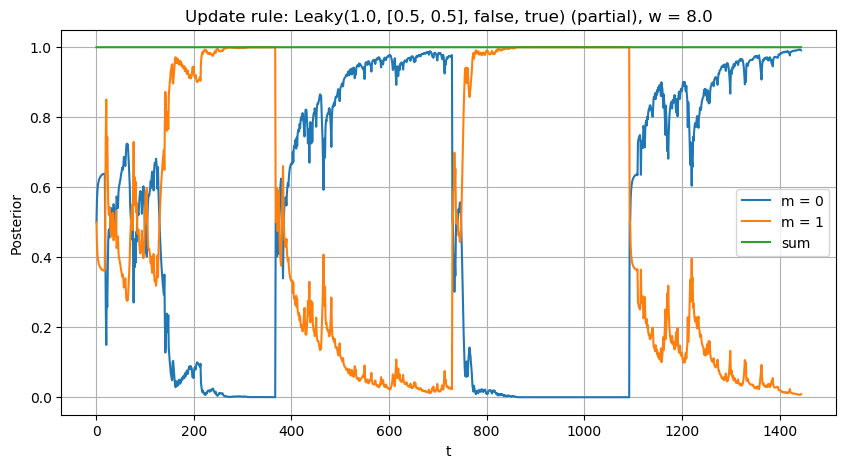

C:\Users\antho\.julia\conda\3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


In [31]:
# plot posterior
ruleidx = 5

start = 1
stop = size(posterior_leaky_partial_inference[ruleidx],1)

x = collect(start:stop)

figure(figsize=[10,5])

for i in 1:size(posterior_leaky_partial_inference[ruleidx],2)
    plot(x, posterior_leaky_partial_inference[ruleidx][start:stop,i], label="m = $(i-1)") 
end

plot(x, sum(posterior_leaky_partial_inference[ruleidx][start:stop,:], dims=2), label="sum")

xlabel("t")
ylabel("Posterior")
title("Update rule: $(models_inference[1][1].str) (partial), w = $(ws[ruleidx])")
grid("on")
legend();

In [36]:
rules_leaky_inference  = map(w -> Leaky(w, prior, leakprior=true, updateallcols=true), ws)
models_inference = [rules_leaky_inference];

In [37]:
posterior_leaky = mapposterior(subdata, models_inference, verbose)
posterior_leaky_inference = posterior_leaky[1];

[2020-06-05T22:08:32.697] mapposterior: decoding sequence for all models


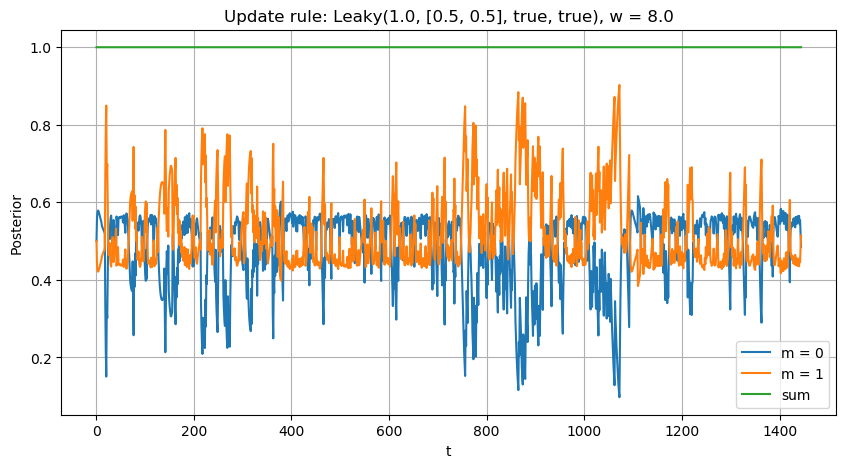

In [38]:
# plot posterior
ruleidx = 5

start = 1
stop = size(posterior_leaky_inference[ruleidx],1)

x = collect(start:stop)

figure(figsize=[10,5])

for i in 1:size(posterior_leaky_inference[ruleidx],2)
    plot(x, posterior_leaky_inference[ruleidx][start:stop,i], label="m = $(i-1)") 
end

plot(x, sum(posterior_leaky_inference[ruleidx][start:stop,:], dims=2), label="sum")

xlabel("t")
ylabel("Posterior")
title("Update rule: $(models_inference[1][1].str), w = $(ws[ruleidx])")
grid("on")
legend();

In [39]:
models_inference = [rules_par_inference];

In [40]:
posterior_par = mapposterior(subdata, models_inference, verbose)
posterior_par_inference = posterior_par[1];

[2020-06-05T22:09:01.356] mapposterior: decoding sequence for all models


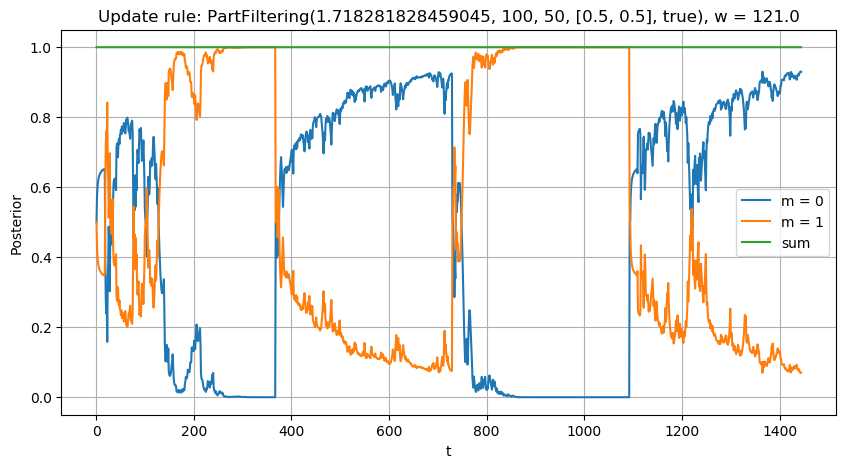

In [44]:
# plot posterior
ruleidx = 10

start = 1
stop = size(posterior_par_inference[ruleidx],1)

x = collect(start:stop)

figure(figsize=[10,5])

for i in 1:size(posterior_par_inference[ruleidx],2)
    plot(x, posterior_par_inference[ruleidx][start:stop,i], label="m = $(i-1)") 
end

plot(x, sum(posterior_par_inference[ruleidx][start:stop,:], dims=2), label="sum")

xlabel("t")
ylabel("Posterior")
title("Update rule: $(models_inference[1][1].str), w = $(ws[ruleidx])")
grid("on")
legend();

In [ ]:
"""
- Block 1 (repetition-biased):  p(A|B) = 1/3, p(B|A) = 1/3;\
- Block 2 (fully stochastic):   p(A|B) = 1/2, p(B|A) = 1/2;\
- Block 3 (alternation-biased): p(A|B) = 2/3, p(B|A) = 2/3;\
- Block 4 (frequency-biased):   p(A|B) = 1/3, p(B|A) = 2/3.
""";

### all m (inference), no normalization, minimum over parameters last

#### Load all models

In [20]:
window_lengths = [0,1,2,3,4]

#############
#### LEAKY
#############
ws = vcat(log2range(0, 10, 54), [Inf])

# leak prior
leaky_models_full = map(
    m -> map(
        w -> Leaky(w, prior_uniform(m), leakprior=true, updateallcols=true),
        ws
    ),
    window_lengths[2:end] # ignore m = 0
)
leaky_models_full = vcat(leaky_models_full...)

# don't leak prior
leaky_models_partial = map(
    m -> map(
        w -> Leaky(w, prior_uniform(m), leakprior=false, updateallcols=true),
        ws
    ),
    window_lengths[2:end] # ignore m = 0
)
leaky_models_partial = vcat(leaky_models_partial...)

# no inference
leaky_models_noinference = map(
    m -> map(
        w -> Leaky(w, prior_fixed(m), leakprior=false, updateallcols=true),
        ws
    ),
    window_lengths
)
leaky_models_noinference = vcat(leaky_models_noinference...)


# particle filtering
nparticles = 1000
nthreshold = Int(nparticles / 2)

pcs = 1 .- exp.(- 1 ./ ws)
ms = pcs ./ (1 .- pcs)

par_models = map(
    wl -> map(
        m -> ParticleFiltering(m, nparticles, nthreshold, prior_uniform(wl)),
        ms
    ),
    window_lengths[2:end] # ignore m = 0
)
par_models = vcat(par_models...)

par_models_noinference = map(
    wl -> map(
        m -> ParticleFiltering(m, nparticles, nthreshold, prior_fixed(wl)),
        ms
    ),
    window_lengths
)
par_models_noinference = vcat(par_models_noinference...)

# models
models = [leaky_models_full, leaky_models_partial, leaky_models_noinference,
          par_models, par_models_noinference]

# slices
slices, slicenames = buildslices()

# subjects
subjects = 1:18

# keep block level
onehotencode_blocks = true;

In [ ]:
dir = "rss"
normalize_meg = false
verbose = 2

pBICs, mBICs = getsubjectsBIC(subjects, models, slices,
    onehotencode_blocks, normalize_meg, dir, verbose);

[2020-06-08T22:14:51.991] getsubjectsBIC: Loading data for subject 1...
[2020-06-08T22:15:00.951] mapBIC: computing RSS...
[2020-06-08T22:15:00.954] mapRSS: Trying to load RSS
[2020-06-08T22:15:00.957] mapRSS: Computing RSS from scratch
[2020-06-08T22:15:00.962] mapsubject: decoding sequence for all models
[2020-06-09T00:08:52.85] mapsaveRSS: computing RSS...

[2020-06-09T00:56:28.966] getsubjectsBIC: Loading data for subject 2...
[2020-06-09T00:56:33.846] mapBIC: computing RSS...
[2020-06-09T00:56:33.848] mapRSS: Trying to load RSS
[2020-06-09T00:56:33.85] mapRSS: Computing RSS from scratch
[2020-06-09T00:56:33.853] mapsubject: decoding sequence for all models
[2020-06-09T01:48:46.538] mapsaveRSS: computing RSS...

[2020-06-09T02:20:02.46] getsubjectsBIC: Loading data for subject 3...
[2020-06-09T02:20:08.267] mapBIC: computing RSS...
[2020-06-09T02:20:08.268] mapRSS: Trying to load RSS
[2020-06-09T02:20:08.271] mapRSS: Computing RSS from scratch
[2020-06-09T02:20:08.274] mapsubject: 

#### Compare all 5 models

In [ ]:
modelnames = ["LeakInfFull", "LeakInfPart", "Leaky", "ParFilInf", "ParFiltering"]

fig = fig5D(mBICs, models, slicenames, modelnames,
    width=15, alpha0=ones(1,5))
display(fig)
clf()

fig = fig5EHeatSpace([ws, ws, ws, 1 ./ ms .+ 1, 1 ./ ms .+ 1], models, pBICs, slicenames,
    modelnames, [4,4,5,4,5], 5)
display(fig)
clf();

#### Compare leaky models

In [ ]:
fig = fig5D(mBICs[:,:,1:3],
    models[1:3],
    slicenames,
    modelnames[1:3],
    width=14)
display(fig)
clf()

fig = fig5EHeatSpace([ws, ws, ws],
    models[1:3],
    pBICs[:,:,1:3],
    slicenames,
    modelnames[1:3],
    [4,4,5],
    1)
display(fig)
clf();

#### Compare particle filtering models

In [ ]:
fig = fig5D(mBICs[:,:,4:5],
    models[4:5],
    slicenames,
    modelnames[4:5],
    width=14)
display(fig)
clf()

fig = fig5EHeatSpace([1 ./ ms .+ 1, 1 ./ ms .+ 1],
    models[4:5],
    pBICs[:,:,4:5],
    slicenames,
    modelnames[4:5],
    [4,5],
    2,
    hidetopaxis=true)
display(fig)
clf();

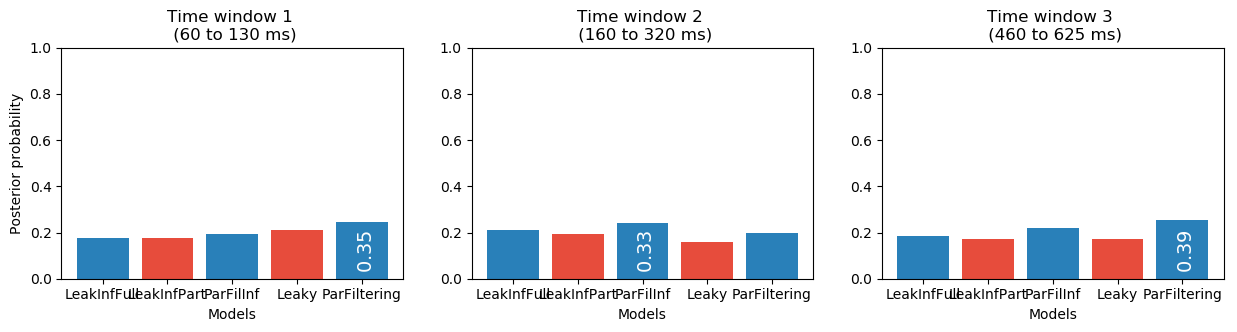

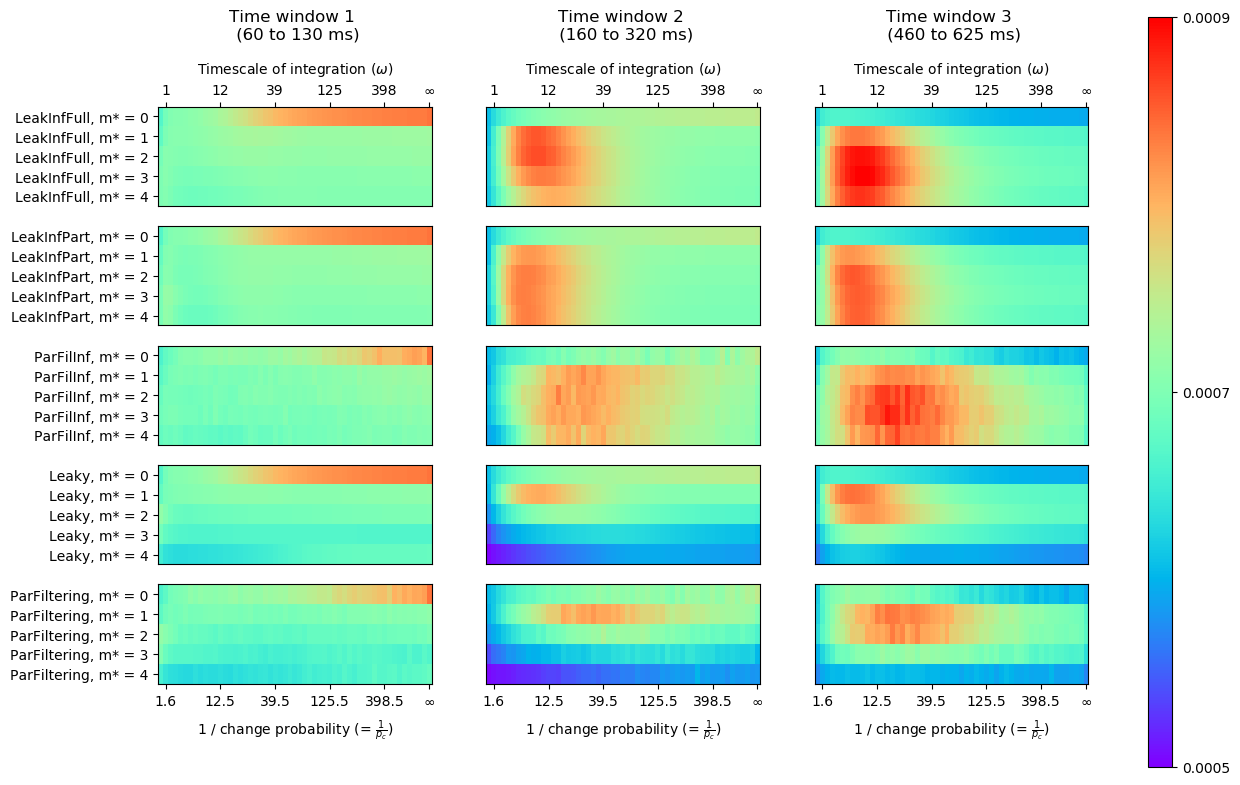

In [159]:
fig = fig5D(cat(mBICs_inference, mBICs, dims=3),
    vcat(models_inference, models),
    slicenames,
    vcat(modelnames_inference, modelnames),
    width=15,
    alpha0=ones(1,5))
display(fig)
clf()

fig = fig5EHeatSpace([ws, ws, 1 ./ ms .+ 1, ws, 1 ./ ms .+ 1], vcat(models_inference, models),
    cat(pBICs_inference, pBICs, dims=3),
    slicenames,
    vcat(modelnames_inference, modelnames),
    length(window_lengths),
    [4,4,4,5,5])
display(fig)
clf();

#### Compare leaky models

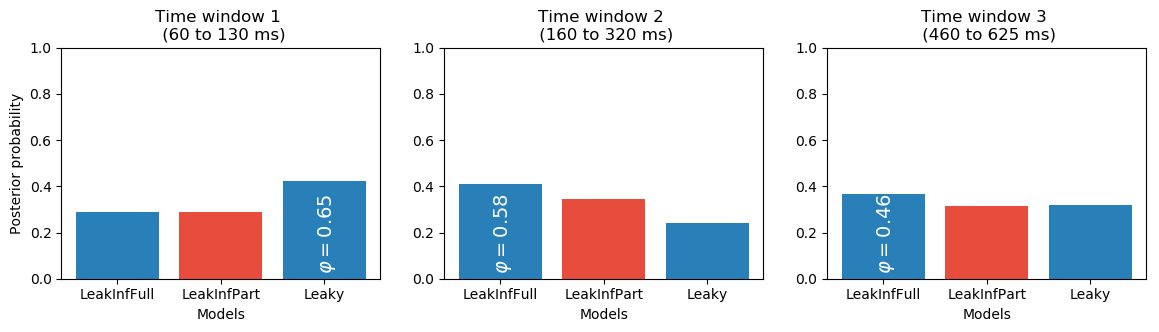

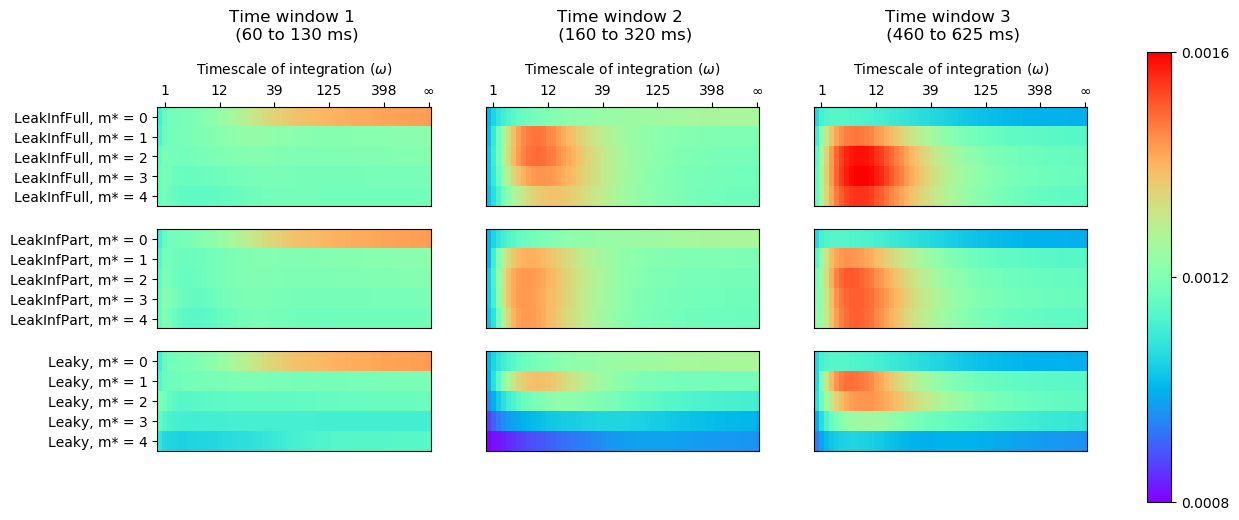

In [75]:
fig = fig5D(cat(mBICs_inference[:,:,1], mBICs_inference[:,:,2], mBICs[:,:,1], dims=3),
    vcat(models_inference[1], models_inference[2], models[1]),
    slicenames,
    vcat(modelnames_inference[1], modelnames_inference[2], modelnames[1]),
    width=14)
display(fig)
clf()

fig = fig5EHeatSpace([ws, ws, ws],
    vcat(models_inference[1], models_inference[2], models[1]),
    cat(pBICs_inference[:,:,1], pBICs_inference[:,:,2], pBICs[:,:,1], dims=3),
    slicenames,
    vcat(modelnames_inference[1], modelnames_inference[2], modelnames[1]),
    length(window_lengths),
    1)
display(fig)
clf();

#### Compare particle filtering models

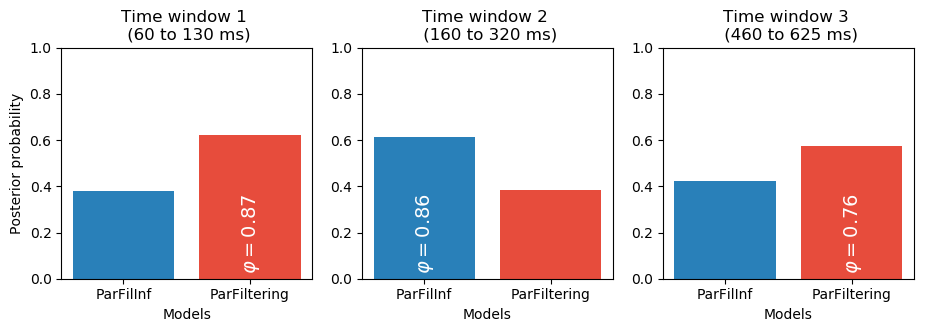

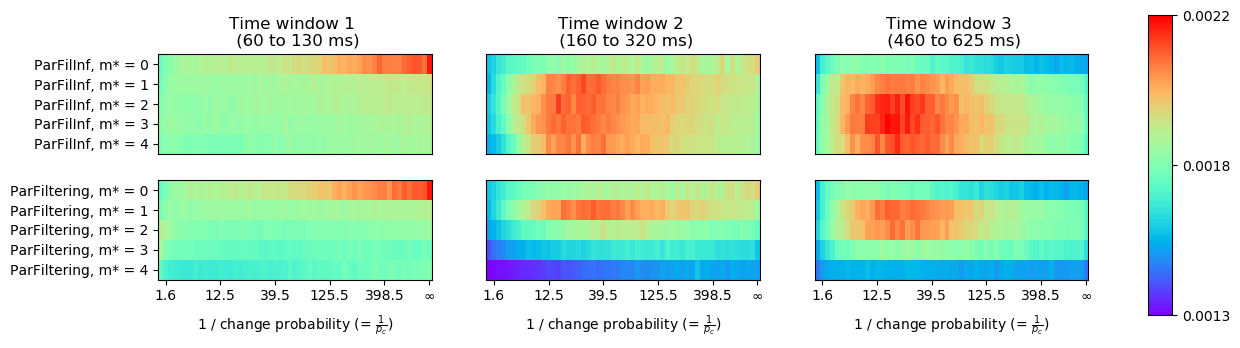

In [84]:
fig = fig5D(cat(mBICs_inference[:,:,3], mBICs[:,:,2], dims=3),
    vcat(models_inference[3], models[2]),
    slicenames,
    vcat(modelnames_inference[3], modelnames[2]))
display(fig)
clf()

fig = fig5EHeatSpace([1 ./ ms .+ 1, 1 ./ ms .+ 1],
    vcat(models_inference[3], models[2]),
    cat(pBICs_inference[:,:,3], pBICs[:,:,2], dims=3),
    slicenames,
    vcat(modelnames_inference[3], modelnames[2]),
    length(window_lengths),
    2,
    hidetopaxis = true)
display(fig)
clf();

## Compare Leaky and VarSMiLe

In [19]:
window_lengths = [0,1,2,3,4]

# leaky
ws = vcat(log2range(0, 10, 54), [Inf])
leaky_rules = build_rules_leaky(ws)
leaky_names = map(m -> "Leaky, " * latexstring("m = $m"), window_lengths)
leaky_models = build_models(leaky_rules, window_lengths, leaky_names)
leaky_models = vcat(leaky_models...)

# varsmile
pcs = 1 .- exp.(- 1 ./ ws)
ms = pcs ./ (1 .- pcs)
varsmile_rules = build_rules_varsmile(ms)
varsmile_names = map(m -> "varSMiLe, " * latexstring("m = $m"), window_lengths)
varsmile_models = build_models(varsmile_rules, window_lengths, varsmile_names)
varsmile_models = vcat(varsmile_models...)

# models
models = [leaky_models, varsmile_models]

# slices
slices, sliceNames = buildslices()

# subjects
subjects = 1:18

# keep block level
onehotencode_blocks = true
;

### all m, normalize, minimum over $\omega$ first

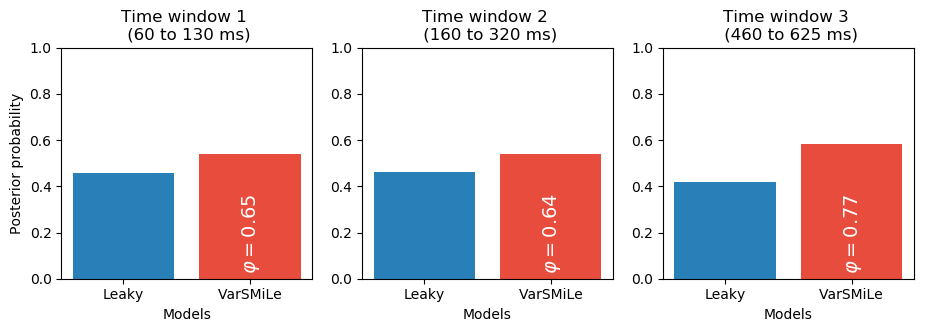

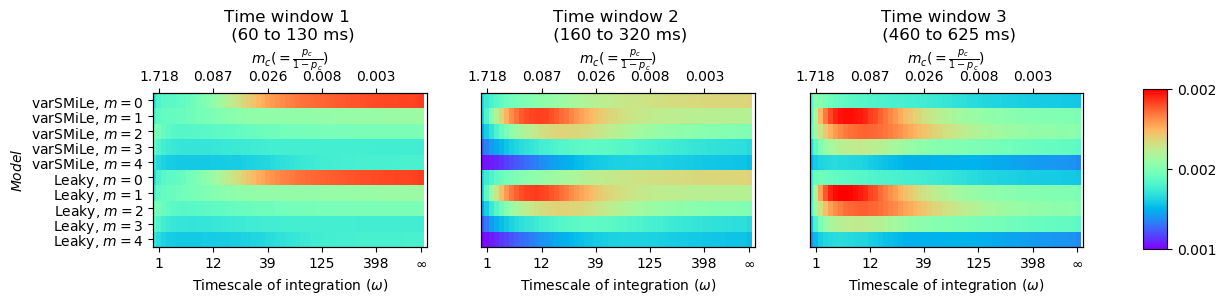

In [32]:
dir = "rss_normalize"
normalize_meg = true
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    pBIC, mBIC = mapRSSToBICMinFirst(RSS, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

modelNames = ["Leaky", "VarSMiLe"]
fig = fig5D(mBICs, models, sliceNames, modelNames)
display(fig)
clf()

fig = fig5EHeat([ws, ms], models, pBICs, sliceNames)
display(fig)
clf()
;

### all m, normalize, minimum over  𝜔  last

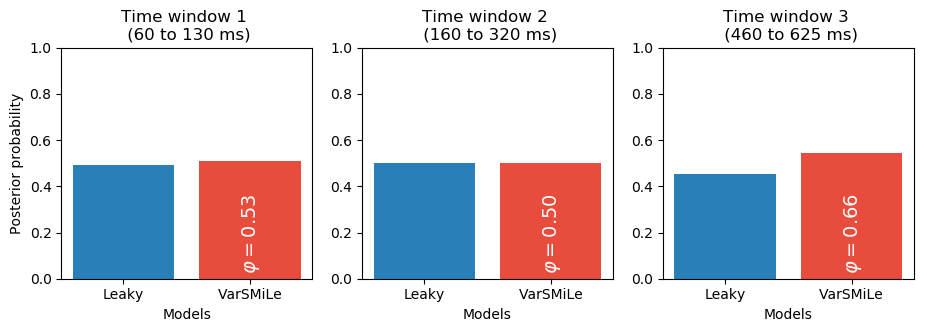

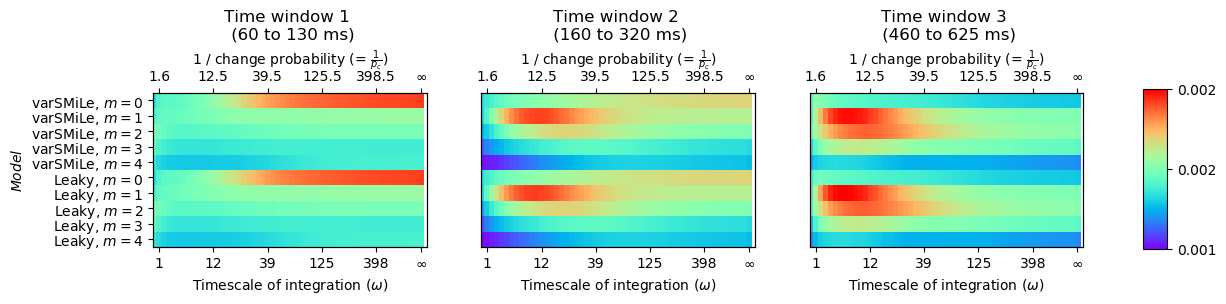

In [43]:
dir = "rss_normalize"
normalize_meg = true
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    pBIC, mBIC = mapRSSToBICMinLast(RSS, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

# figures
modelNames = ["Leaky", "VarSMiLe"]
fig = fig5D(mBICs, models, sliceNames, modelNames)
display(fig)
clf()

fig = fig5EHeat([ws, 1 ./ ms .+ 1], models, pBICs, sliceNames)
display(fig)
clf()
;

In [123]:
function fig5EHeatSpace(params, models, pBICs, sliceNames)
    # heatmap
    
    # we assume there are the same number of rules per model
    BICs = zeros(size(pBICs,1), size(pBICs,2), size(pBICs,3)*length(pBICs[1,1,1]))
    for slice in 1:size(pBICs,1)
        for subject in 1:size(pBICs,2)
            BICs[slice,subject,:] = vcat(pBICs[slice,subject,:]...)
        end
    end
    
    # compute posterior probabilites
    posterior = computePosterior(BICs)

    # map to inter-subject mean
    posterior = permutedims(posterior, (2,1,3))
    means = map(mean(slice), Slices(posterior, 1))

    vmin = findmin(means)[1]
    vmax = findmax(means)[1]
    
    #vmin = 0.007
    #vmax = 0.012
    
    # find number of window lengths
    names = map(m -> unique(map(rule -> rule["name"], m)), models)
    Nm = length(names[1])
    #names = vcat(names...)
    
    step = 11
    xticks = @pipe 1:step:length(params[1]) |> collect |> vcat(_, [length(params[1])-1])
    xlabels = @pipe params[1][1:step:end] |> 
                    Int.(_) |> 
                    string.(_) |> 
                    vcat(_, [L"\infty"])
    
    if length(params) == 2 && params[1] != params[2]
        use2Axes = true
        step2 = step
        xticks2 = @pipe 1:step2:length(params[2]) |> 
                        collect |> 
                        vcat(_, [length(params[2])-1])
        
        xlabels2 = @pipe params[2][1:step2:end] |>
                         map(p -> @sprintf("%.1f", p), _) |>
                         vcat(_, [L"\infty"])
    else
        use2Axes = false
        xticks2 = []
        xlabels2 = []
    end
    aspect = 2 * 10 / Nm

    # create plot
    fig = figure("Different integration horizons", figsize=(12,3))
    heatmap = undef

    for i in 1:size(means,1)
        
        for j in 1:2
            ax = subplot(230 + (j-1)*3 + i)
            ax.set_xlim([0, length(params[j])])

            # plot
            values = reshape(means[i,(1 + (j-1)*length(params[j])*Nm):length(params[j])*Nm*j], (length(params[j]), Nm))
            heatmap = ax.imshow(values',
                cmap="rainbow",
                interpolation="nearest",
                #extent=[-0.5, length(params[1])-0.5, -0.5, Nm * length(models) - 0.5],
                vmin=vmin,
                vmax=vmax)

            # set x and y axis labels
            ax.set_aspect(aspect)
            
            if j == 1
                ax.xaxis.set_ticks_position("top")
                ax.xaxis.set_label_position("top")
            end
            
            ax.set_xlabel(j == 1 ? L"Timescale of integration ($\omega$)" : L"1 / change probability (= $\frac{1}{p_c})$", labelpad=7)
            ax.set_xticks(j == 1 ? xticks : xticks2)
            ax.set_xticklabels(j == 1 ? xlabels : xlabels2)
            
            if j == 1
               # add title
                PyPlot.title(@sprintf("Time window %i \n (%s)", i, sliceNames[i]), y=1.6) 
            end

            # add second axis
            #if use2Axes
            #    ax2.set_aspect(aspect)            
            #    ax2.set_xlabel()
            #    ax2.set_xticks(xticks2)
            #    ax2.set_xticklabels(xlabels2)
            #end"""

            # set y axis
            if i == 1
                ax.set_yticks(collect(1:Nm) .- 1)
                ax.set_yticklabels(names[j])
            else
                ax.set_yticks([])
            end
        end
                
    end

    cbaxes = fig.add_axes([0.95, 0, 0.02, 1]) 
    cbar = colorbar(heatmap, shrink=0.46, cax=cbaxes)
    rnd(x) = @sprintf("%.4f", x)
    vals = [vmin,(vmin+vmax)/2.0,vmax]
    cbar.set_ticks(vals)
    cbar.set_ticklabels(rnd.(vals))
    
    return fig
end
;

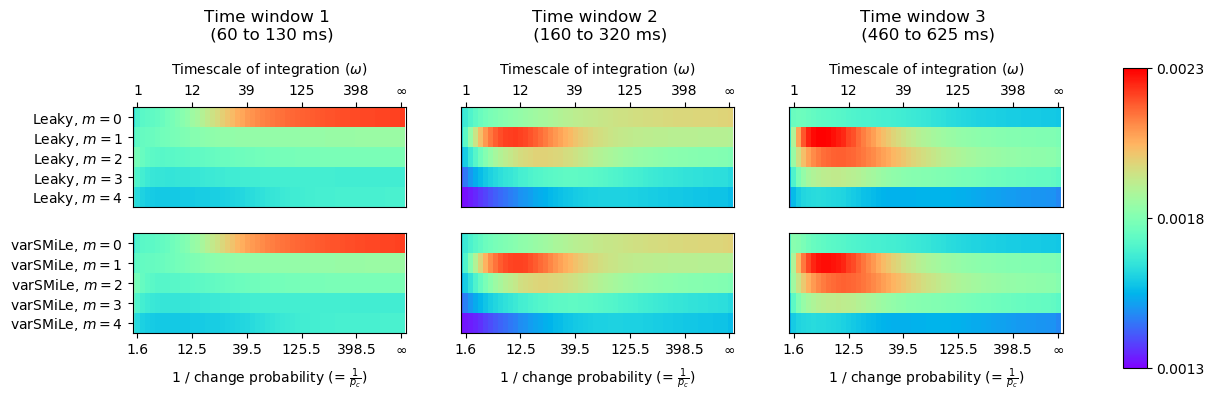

In [124]:
fig = fig5EHeatSpace([ws, 1 ./ ms .+ 1], models, pBICs, sliceNames)
display(fig)
clf()
;

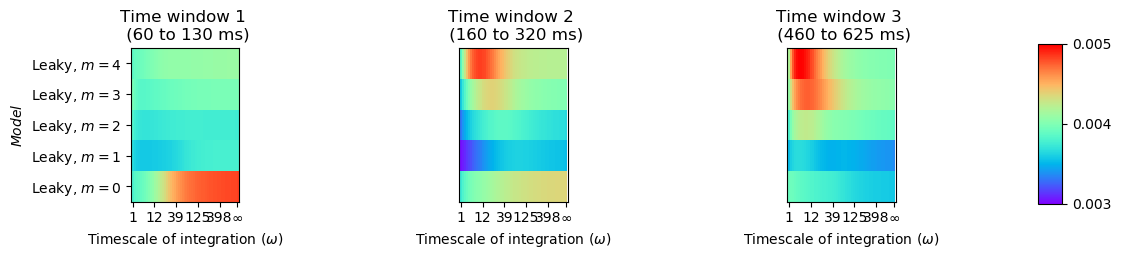

In [47]:
models_leaky_all = []
pBICS_leaky_all = Array{Array{Float64,1},3}(undef,3,18,5)
for i in 1:5
    push!(models_leaky_all, models[1][(1 + (i-1)*55):(55 * i)])
    for sl in 1:3, su in 1:18 
        pBICS_leaky_all[sl,su,i] = pBICs[sl,su,1][(1 + (i-1)*55):(55 * i)]
    end
end

fig = fig5EHeat([ws], models_leaky_all, pBICS_leaky_all, sliceNames)
display(fig)
clf()
;

### all m, no normalization, minimum over  𝜔  first

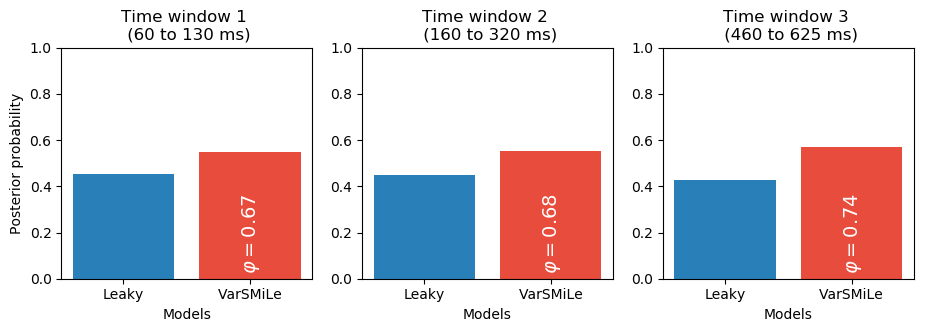

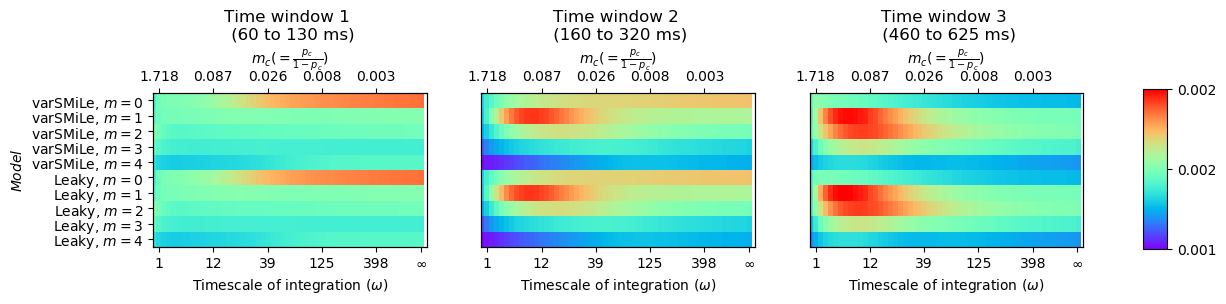

In [33]:
dir = "rss_raw"
normalize_meg = false
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    pBIC, mBIC = mapRSSToBICMinFirst(RSS, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

modelNames = ["Leaky", "VarSMiLe"]
fig = fig5D(mBICs, models, sliceNames, modelNames)
display(fig)
clf()

fig = fig5EHeat([ws, ms], models, pBICs, sliceNames)
display(fig)
clf()
;

### all m, no normalization, minimum over  𝜔  last

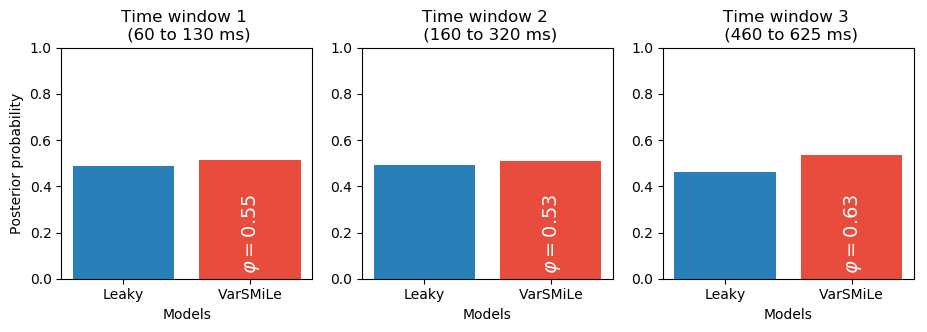

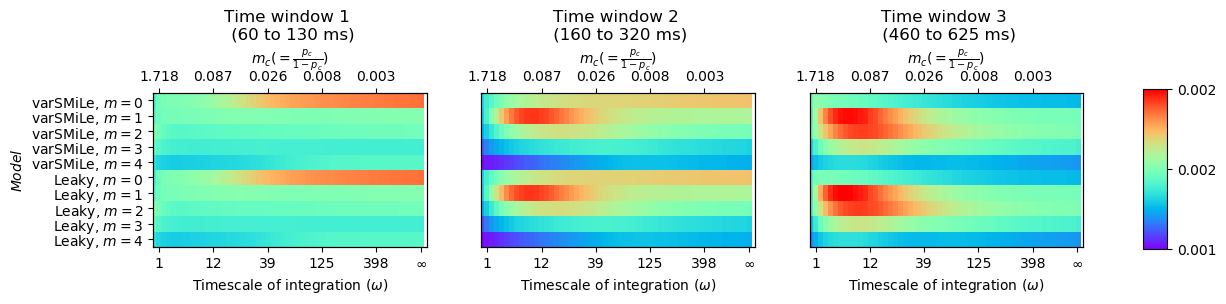

In [35]:
dir = "rss_raw"
normalize_meg = false
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    pBIC, mBIC = mapRSSToBICMinLast(RSS, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

modelNames = ["Leaky", "VarSMiLe"]
fig = fig5D(mBICs, models, sliceNames, modelNames)
display(fig)
clf()

fig = fig5EHeat([ws, ms], models, pBICs, sliceNames)
display(fig)
clf()
;

# Leaky

### $m \in [0,1]$, leaky, normalize, minimum over $\omega$ first

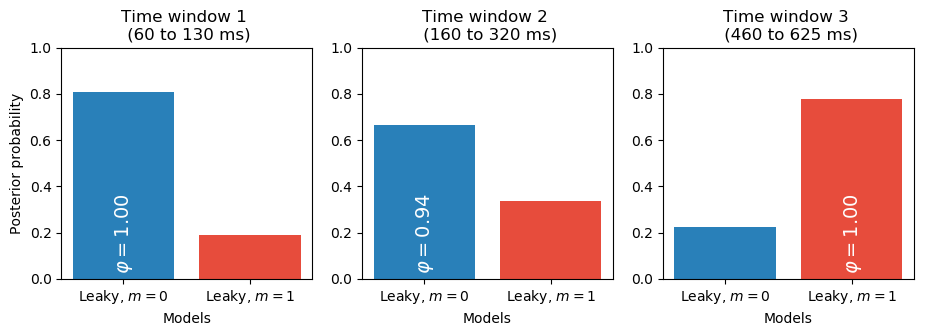

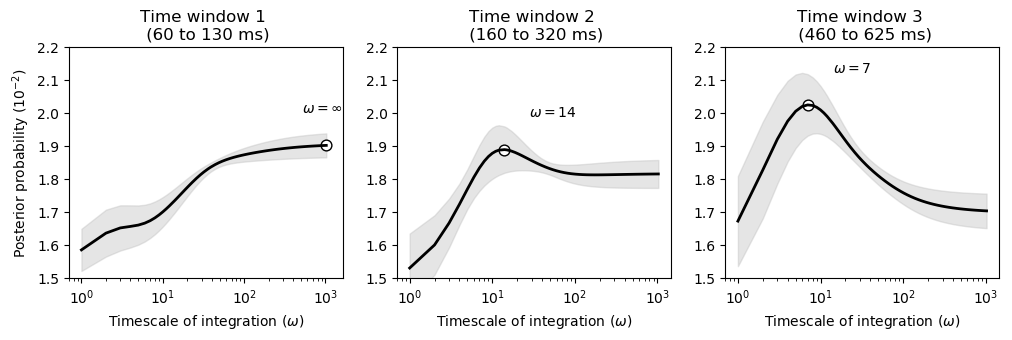

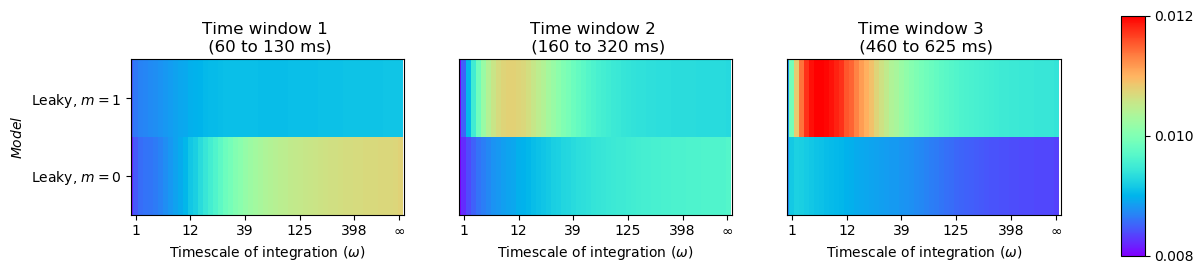

In [56]:
dir = "rss_normalize"
normalize_meg = true
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    
    # extract leaky m = 0 and m = 1
    RSS_leaky = Array{Array{Float64,3},2}(undef, length(slices), 2)
    for s in eachindex(slices)
        RSS_leaky[s,1] = RSS[s,1][1:55,:,:]
        RSS_leaky[s,2] = RSS[s,1][56:110,:,:]
    end
    
    pBIC, mBIC = mapRSSToBICMinFirst(RSS_leaky, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

models_leaky_0 = models[1][1:55]
models_leaky_1 = models[1][56:110]
models_leaky_t = [models_leaky_0, models_leaky_1]

# figures
modelNames = [L"Leaky, $m = 0$", L"Leaky, $m = 1$"]
fig = fig5D(mBICs, models_leaky_t, sliceNames, modelNames)
display(fig)
clf()

fig = fig5E(ws, pBICs, sliceNames)
display(fig)
clf()

fig = fig5EHeat([ws], models_leaky_t, pBICs, sliceNames)
display(fig)
clf()
;

### $m \in [0,1]$, leaky, normalize, minimum over $\omega$ last

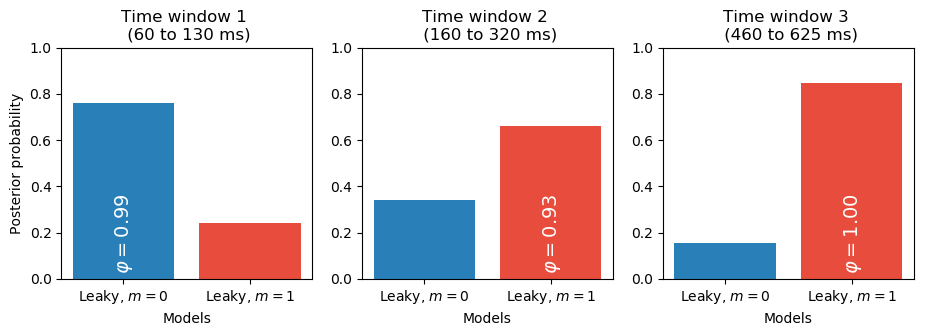

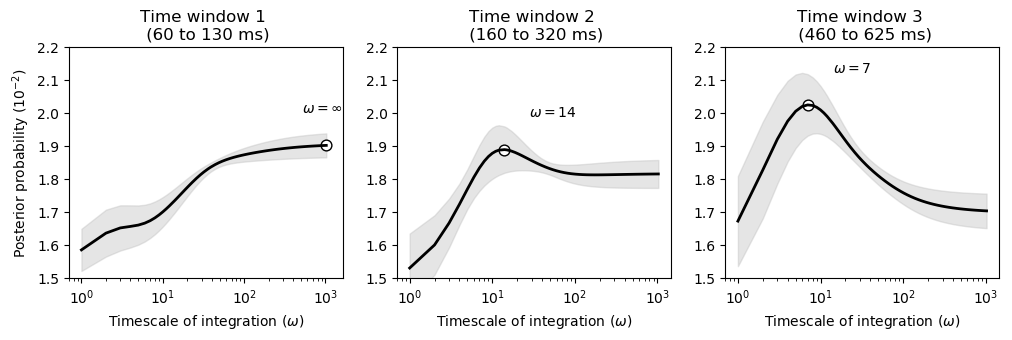

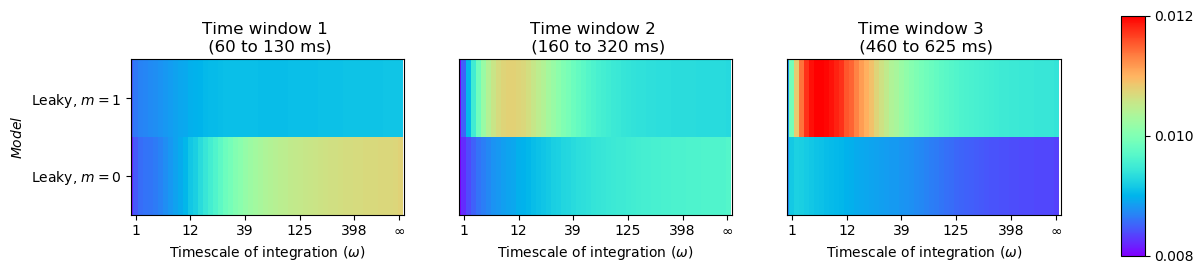

In [57]:
dir = "rss_normalize"
normalize_meg = true
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    
    # extract leaky m = 0 and m = 1
    RSS_leaky = Array{Array{Float64,3},2}(undef, length(slices), 2)
    for s in eachindex(slices)
        RSS_leaky[s,1] = RSS[s,1][1:55,:,:]
        RSS_leaky[s,2] = RSS[s,1][56:110,:,:]
    end
    
    pBIC, mBIC = mapRSSToBICMinLast(RSS_leaky, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

models_leaky_0 = models[1][1:55]
models_leaky_1 = models[1][56:110]
models_leaky_t = [models_leaky_0, models_leaky_1]

# figures
modelNames = [L"Leaky, $m = 0$", L"Leaky, $m = 1$"]
fig = fig5D(mBICs, models_leaky_t, sliceNames, modelNames)
display(fig)
clf()

fig = fig5E(ws, pBICs, sliceNames)
display(fig)
clf()

fig = fig5EHeat([ws], models_leaky_t, pBICs, sliceNames)
display(fig)
clf()
;

### $m \in [0,1]$, leaky, no normalization, minimum over $\omega$ first

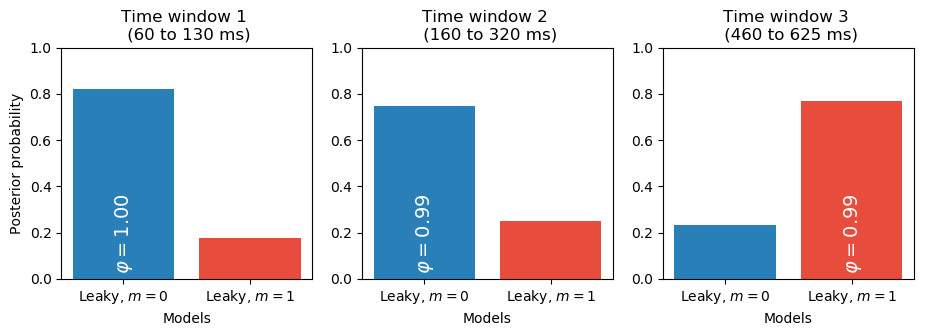

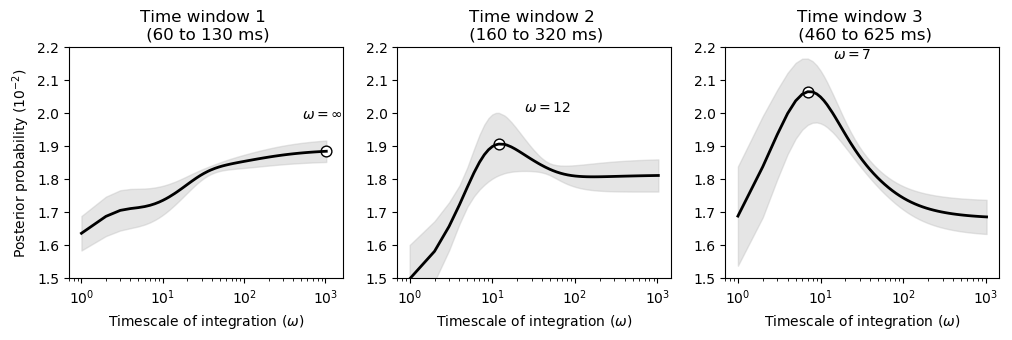

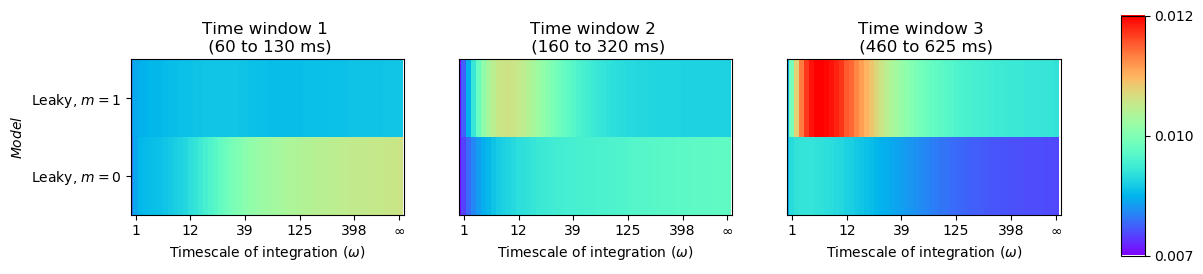

In [58]:
dir = "rss_raw"
normalize_meg = false
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    
    # extract leaky m = 0 and m = 1
    RSS_leaky = Array{Array{Float64,3},2}(undef, length(slices), 2)
    for s in eachindex(slices)
        RSS_leaky[s,1] = RSS[s,1][1:55,:,:]
        RSS_leaky[s,2] = RSS[s,1][56:110,:,:]
    end
    
    pBIC, mBIC = mapRSSToBICMinFirst(RSS_leaky, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

models_leaky_0 = models[1][1:55]
models_leaky_1 = models[1][56:110]
models_leaky_t = [models_leaky_0, models_leaky_1]

# figures
modelNames = [L"Leaky, $m = 0$", L"Leaky, $m = 1$"]
fig = fig5D(mBICs, models_leaky_t, sliceNames, modelNames)
display(fig)
clf()

fig = fig5E(ws, pBICs, sliceNames)
display(fig)
clf()

fig = fig5EHeat([ws], models_leaky_t, pBICs, sliceNames)
display(fig)
clf()
;

### $m \in [0,1]$, leaky, no normalization, minimum over $\omega$ last

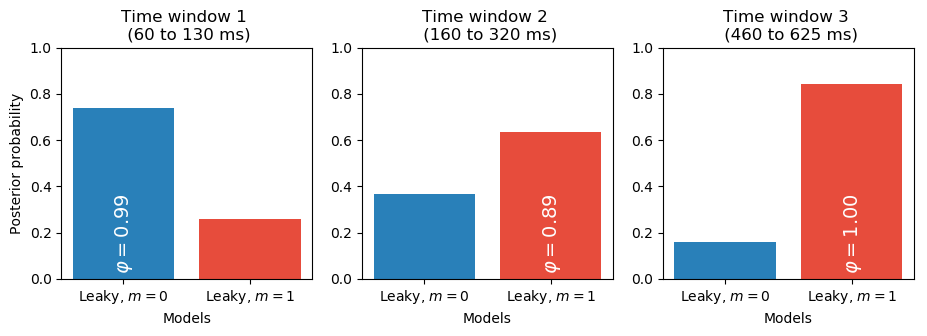

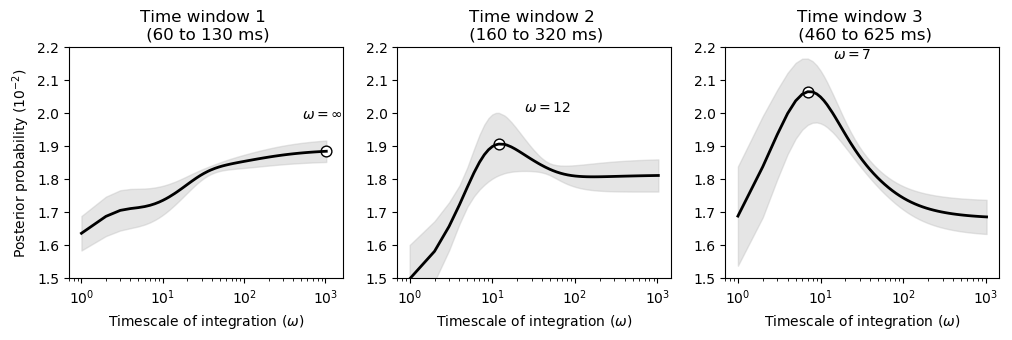

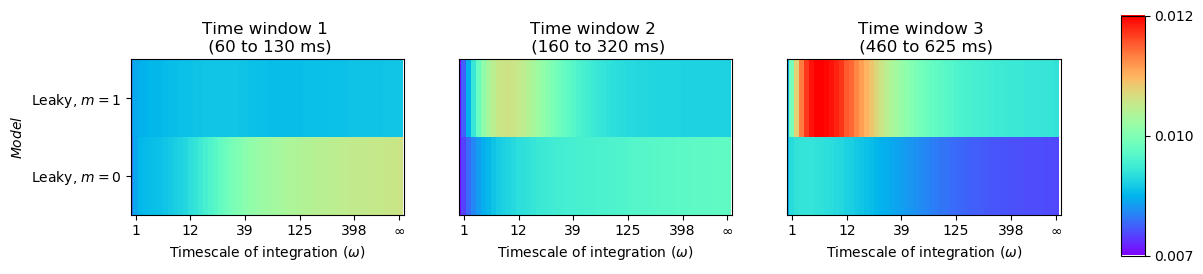

In [59]:
dir = "rss_raw"
normalize_meg = false
verbose = 0

pBICs = Array{Array{Float64,1},3}(undef, length(subjects), length(slices), length(models))
mBICs = zeros(length(subjects), length(slices), length(models))

for subject in subjects
    RSS, N = mapRSS(nothing, subject, models, slices, onehotencode_blocks, normalize_meg, dir, verbose)
    
    # extract leaky m = 0 and m = 1
    RSS_leaky = Array{Array{Float64,3},2}(undef, length(slices), 2)
    for s in eachindex(slices)
        RSS_leaky[s,1] = RSS[s,1][1:55,:,:]
        RSS_leaky[s,2] = RSS[s,1][56:110,:,:]
    end
    
    pBIC, mBIC = mapRSSToBICMinLast(RSS_leaky, N, slices, models)
    
    pBICs[subject,:,:] = pBIC
    mBICs[subject,:,:] = mBIC
end

# reshape according to slices first
pBICs = permutedims(pBICs, (2, 1, 3))
mBICs = permutedims(mBICs, (2, 1, 3))

models_leaky_0 = models[1][1:55]
models_leaky_1 = models[1][56:110]
models_leaky_t = [models_leaky_0, models_leaky_1]

# figures
modelNames = [L"Leaky, $m = 0$", L"Leaky, $m = 1$"]
fig = fig5D(mBICs, models_leaky_t, sliceNames, modelNames)
display(fig)
clf()

fig = fig5E(ws, pBICs, sliceNames)
display(fig)
clf()

fig = fig5EHeat([ws], models_leaky_t, pBICs, sliceNames)
display(fig)
clf()
;

In [20]:
# m = 0,1
mBICs = importBIC("mBICs_all_01.mat")
pBICs = importBIC("pBICs_all_01.mat")
;

In [ ]:
# m = 0,1,2
mBICs = importBIC("mBICs_all_012.mat")
pBICs = importBIC("pBICs_all_012.mat")
;

## Leaky by block

In [29]:
# leaky
ws = vcat(log2range(0, 10, 54), [Inf])
leaky_rules = build_rules_leaky(ws)
leaky_models = build_models(leaky_rules, [0,1])

# slices
slices, sliceNames = buildslices()

# subjects
subjects = 1:18

# do computation
normalize_meg = true
verbose = 2
;

In [39]:
pBICsByBlock = importBIC("pBICsBlock_dep.mat")
mBICsByBlock = importBIC("mBICsBlock_dep.mat")
;

In [ ]:
pBICsByBlock = importBIC("pBICsBlock_indep.mat")
mBICsByBlock = importBIC("mBICsBlock_indep.mat")
;

In [30]:
normalize_meg = true
pBICsByBlock, mBICsByBlock = getBICByBlockForSubjects(subjects, leaky_models, slices, 
    true, normalize_meg, verbose)
;

[2020-05-06T00:01:48.33] Loading data for subject 1...
[2020-05-06T00:01:56.622] mapSubject: decoding sequence for all rules
[2020-05-06T00:01:58.535] mapSubject: decoding MEG
[2020-05-06T00:02:00.789] mapBICByBlock: computing RSS...

[2020-05-06T00:24:01.413] Loading data for subject 2...
[2020-05-06T00:24:05.977] mapSubject: decoding sequence for all rules
[2020-05-06T00:24:06.564] mapSubject: decoding MEG
[2020-05-06T00:24:09.081] mapBICByBlock: computing RSS...

[2020-05-06T00:48:37.585] Loading data for subject 3...
[2020-05-06T00:48:42.836] mapSubject: decoding sequence for all rules
[2020-05-06T00:48:43.062] mapSubject: decoding MEG
[2020-05-06T00:48:45.007] mapBICByBlock: computing RSS...

[2020-05-06T01:15:36.105] Loading data for subject 4...
[2020-05-06T01:15:41.436] mapSubject: decoding sequence for all rules
[2020-05-06T01:15:41.671] mapSubject: decoding MEG
[2020-05-06T01:15:44.066] mapBICByBlock: computing RSS...

[2020-05-06T01:45:33.116] Loading data for subject 5...
[

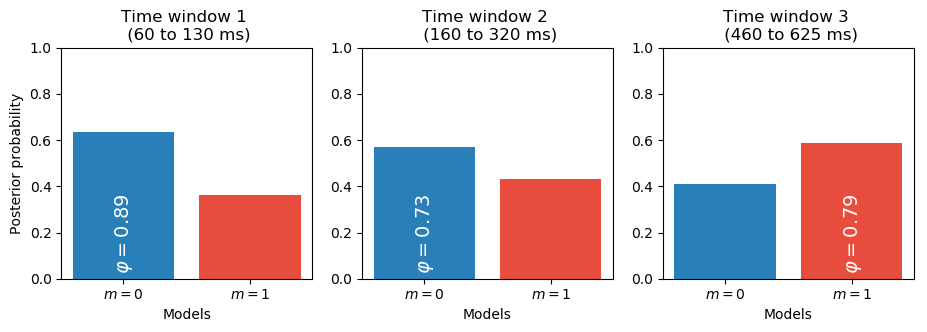

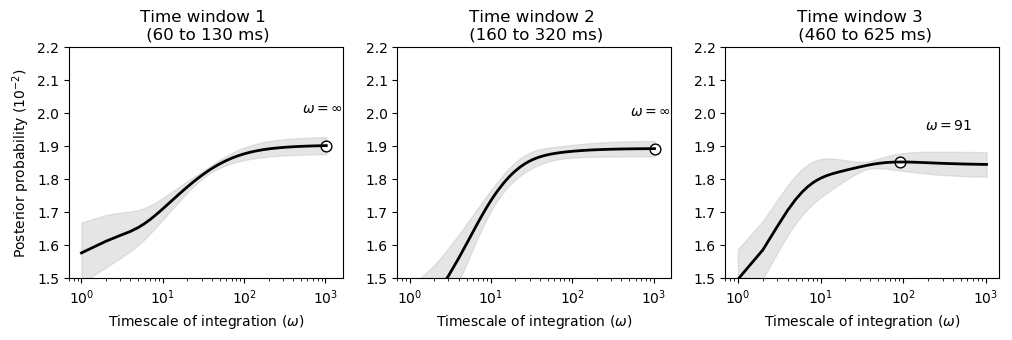

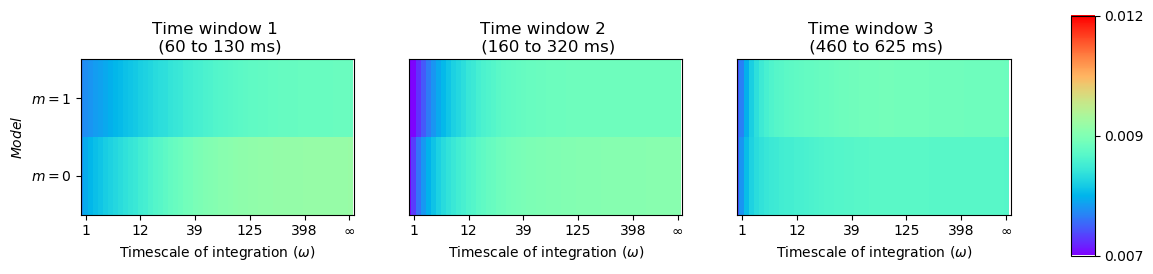

In [35]:

block = 4
fig = fig5D(mBICsByBlock[block,:,:,:], leaky_models, sliceNames)
display(fig)
clf()

fig = fig5E(ws, pBICsByBlock[block,:,:,:], sliceNames)
display(fig)
clf()

fig = fig5EHeat([ws], leaky_models, pBICsByBlock[block,:,:,:], sliceNames)
display(fig)
clf()

[2020-05-06T08:27:56.056] BLOCK 1


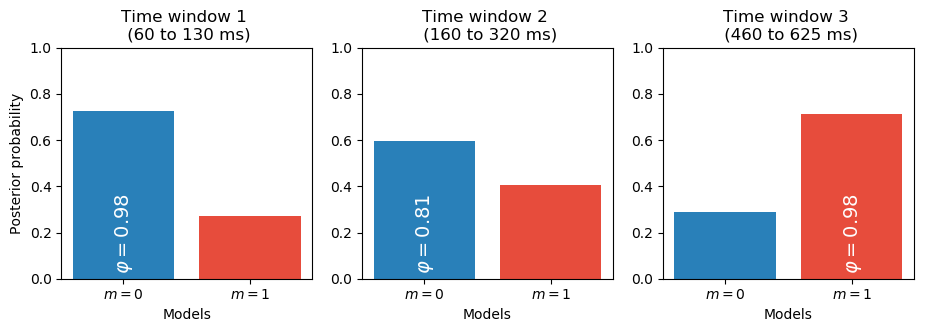

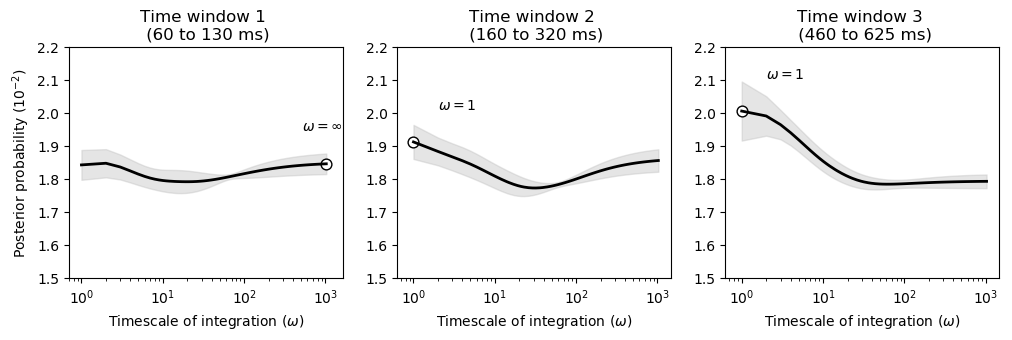

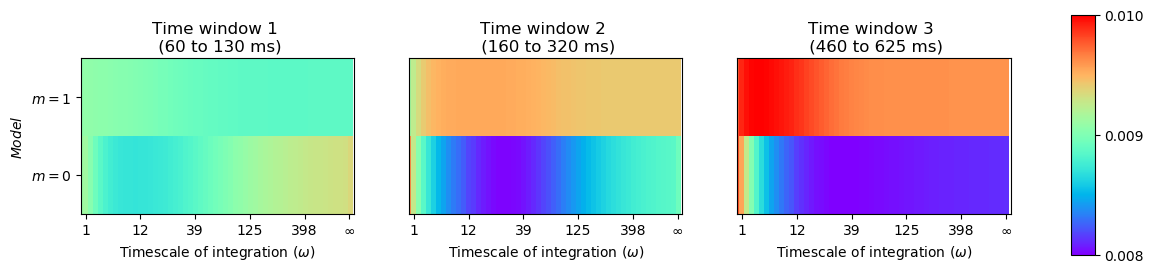

[2020-05-06T08:28:00.425] BLOCK 2


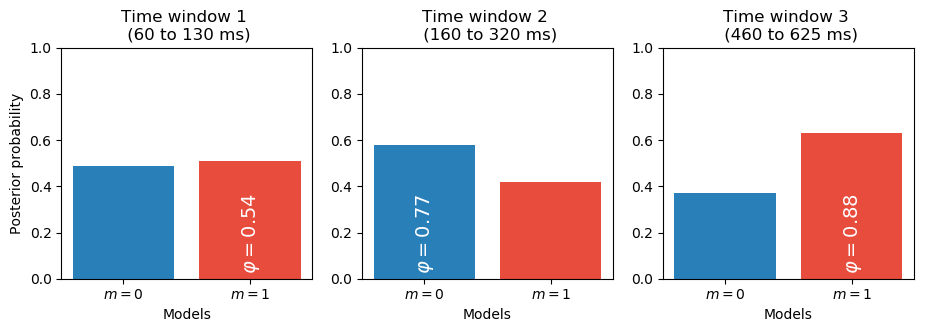

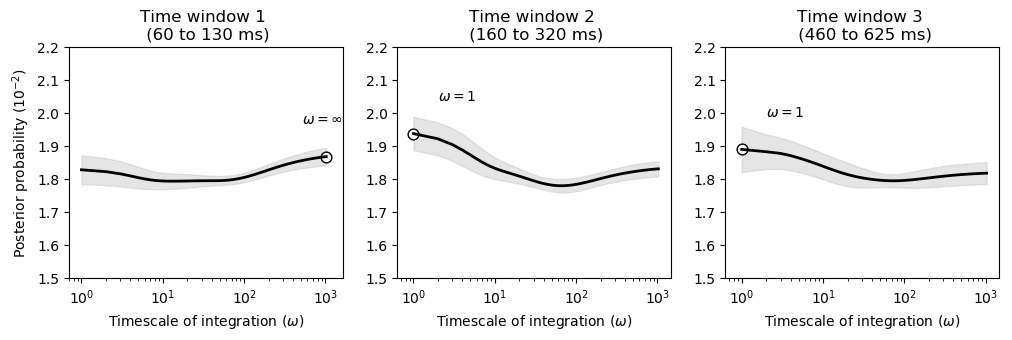

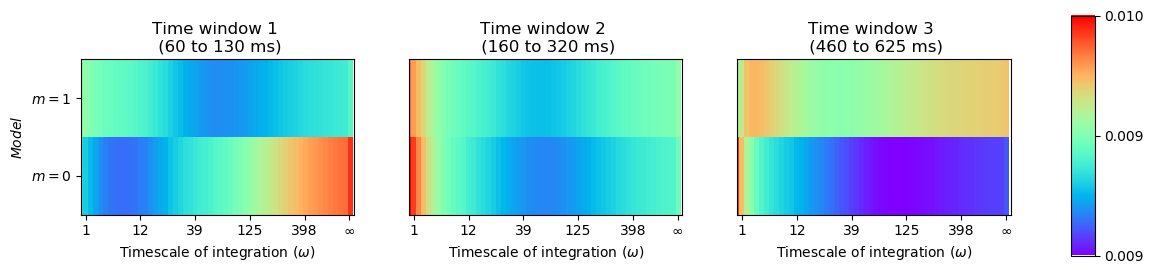

[2020-05-06T08:28:02.256] BLOCK 3


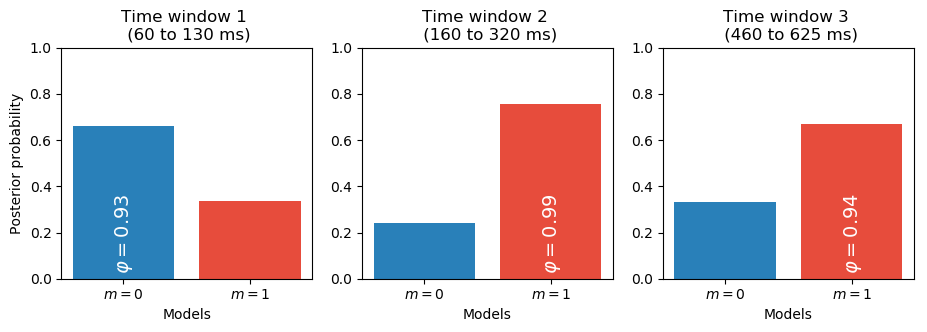

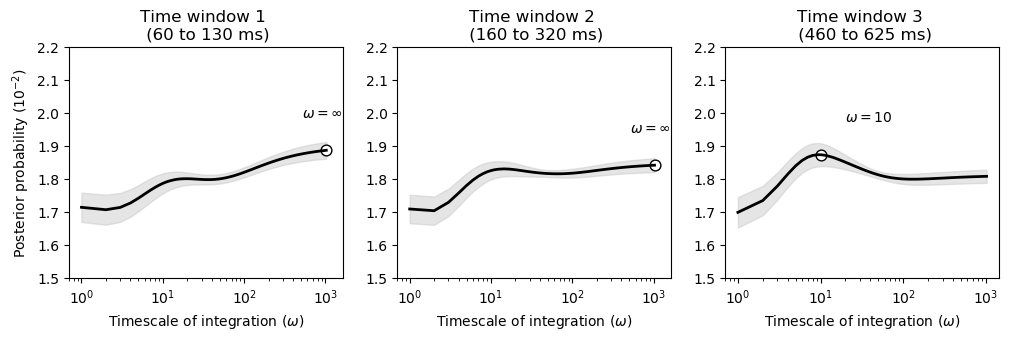

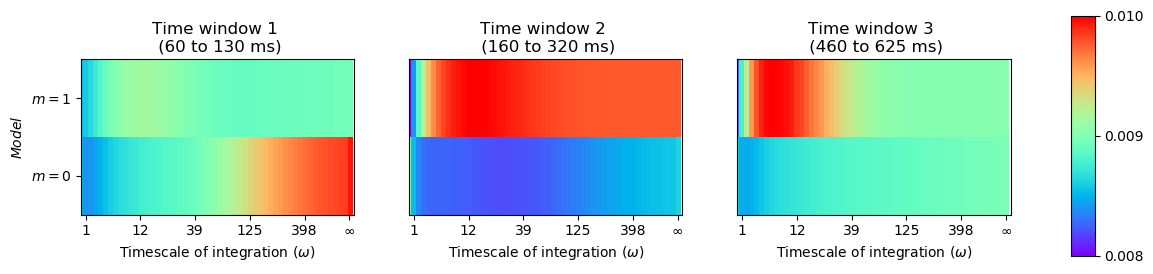

[2020-05-06T08:28:04.072] BLOCK 4


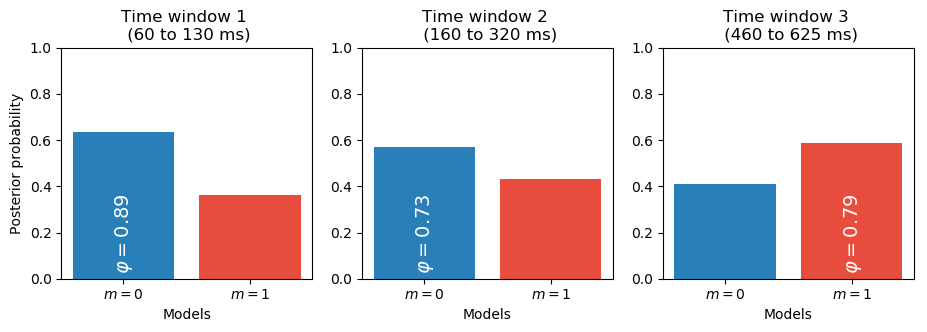

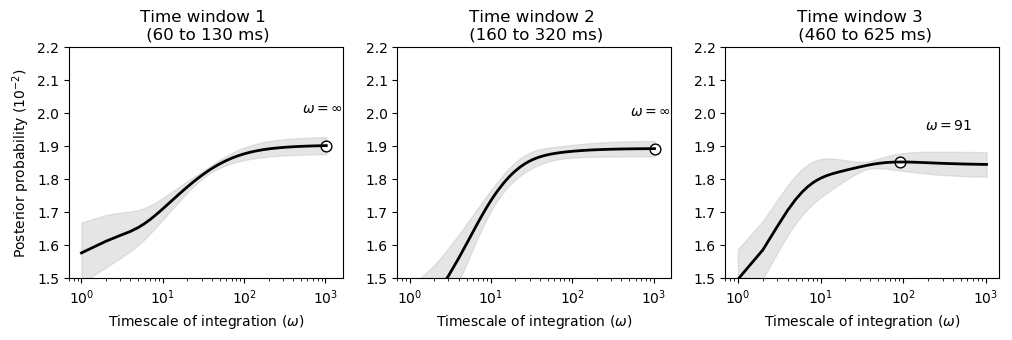

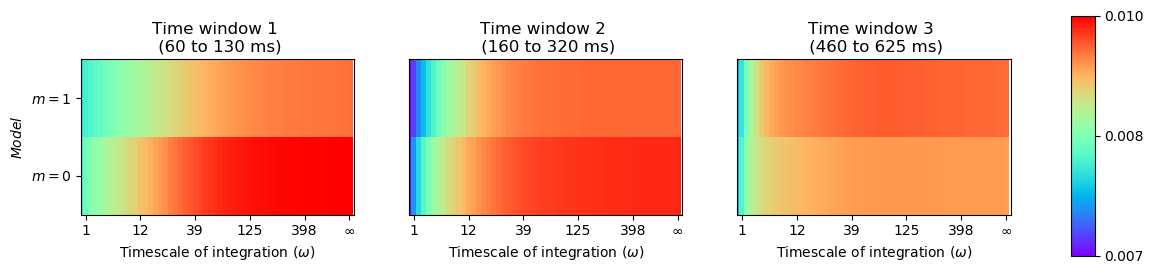

In [31]:
blocks = 4
for block in 1:blocks
    lg("BLOCK $block")
    
    fig = fig5D(mBICsByBlock[block,:,:,:], leaky_models, sliceNames)
    display(fig)
    clf()

    fig = fig5E(ws, pBICsByBlock[block,:,:,:], sliceNames)
    display(fig)
    clf()

    fig = fig5EHeat([ws], leaky_models, pBICsByBlock[block,:,:,:], sliceNames)
    display(fig)
    clf()
end

[2020-04-27T10:51:59.431] BLOCK 1


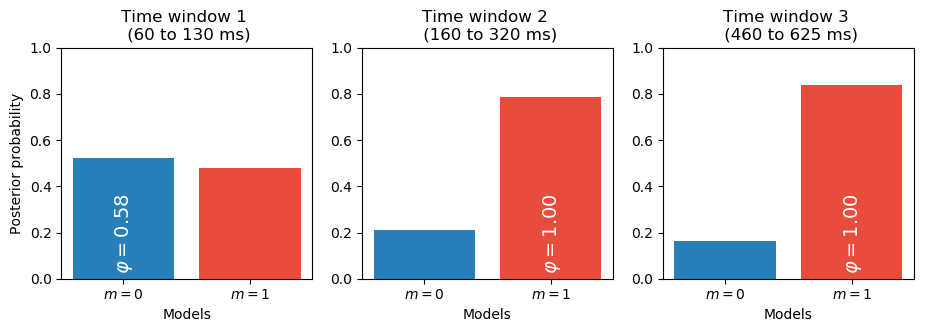

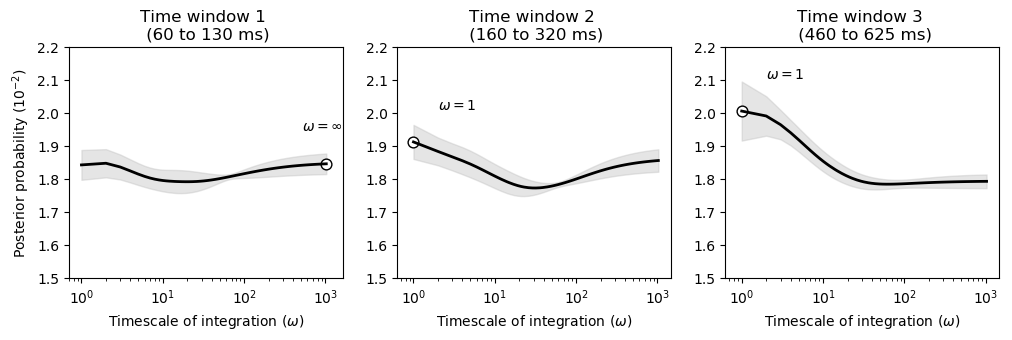

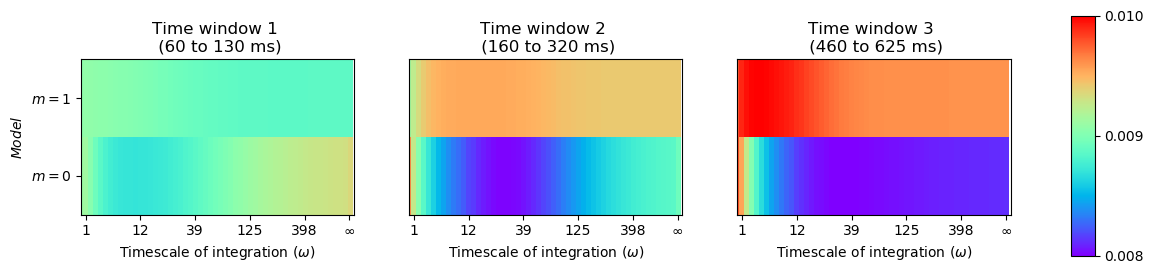

[2020-04-27T10:52:02.289] BLOCK 2


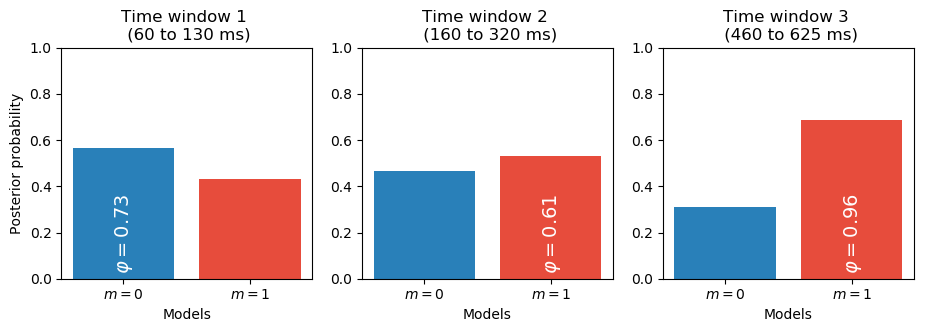

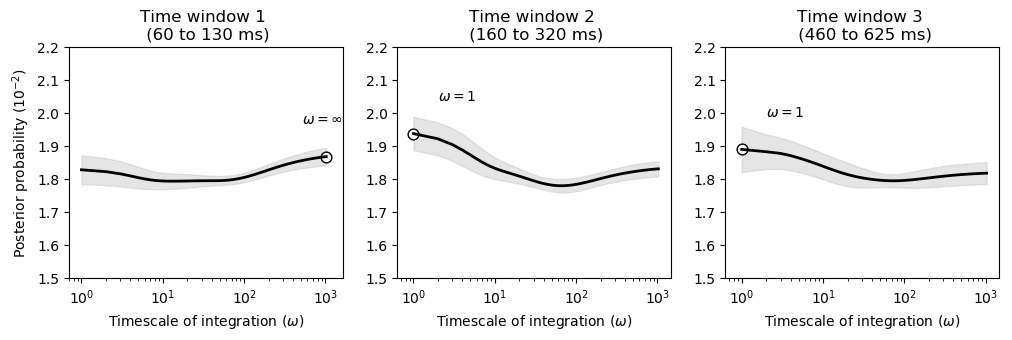

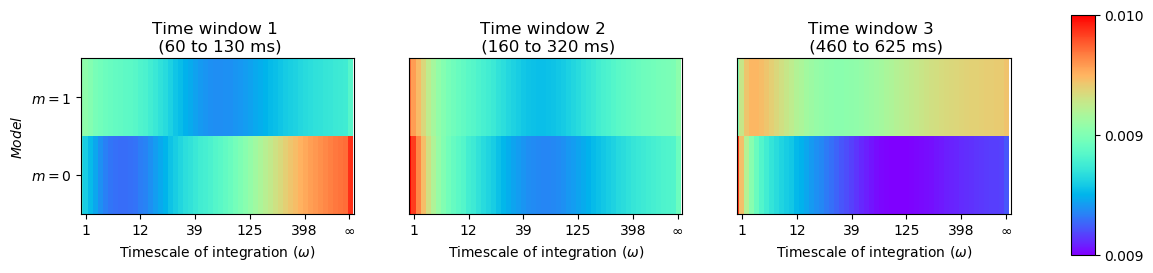

[2020-04-27T10:52:04.536] BLOCK 3


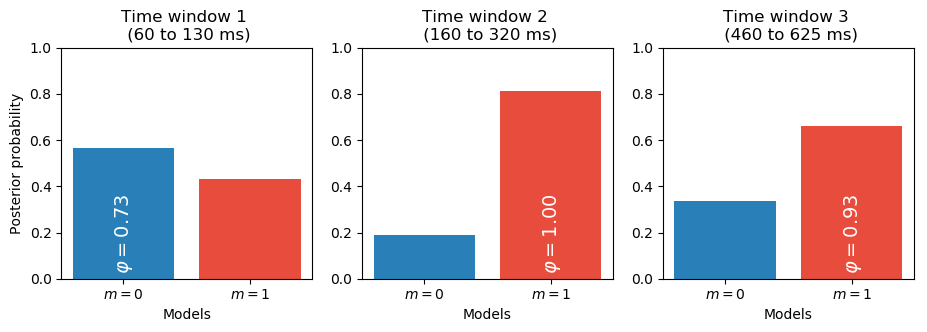

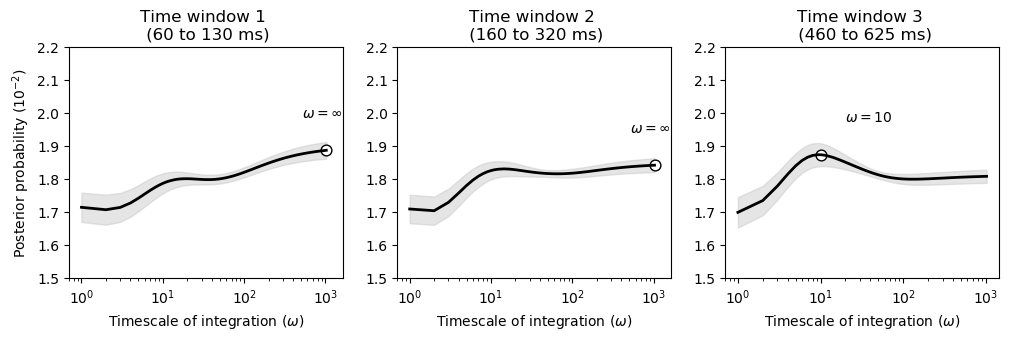

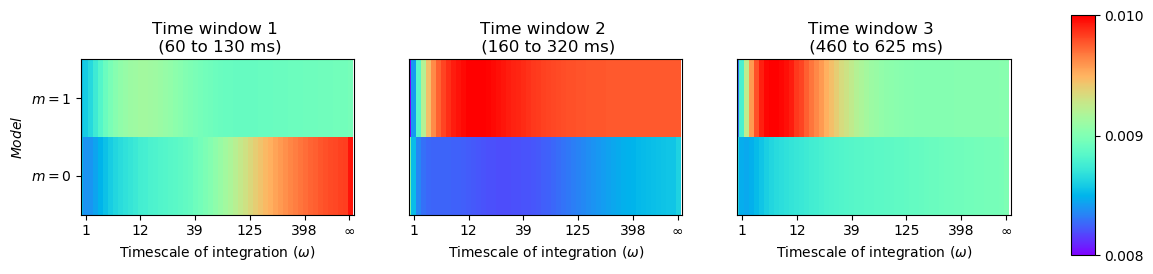

[2020-04-27T10:52:06.76] BLOCK 4


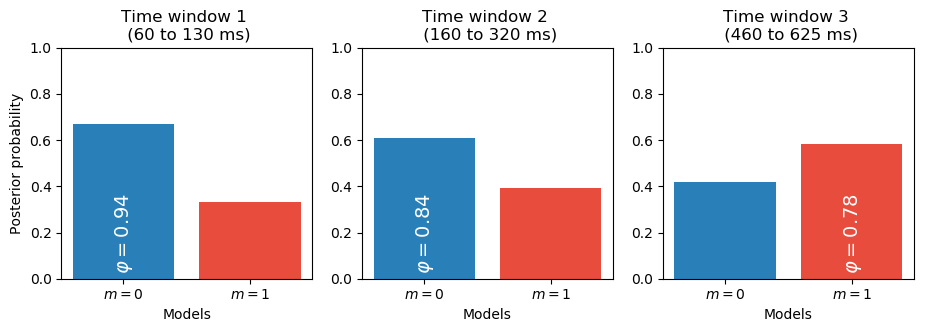

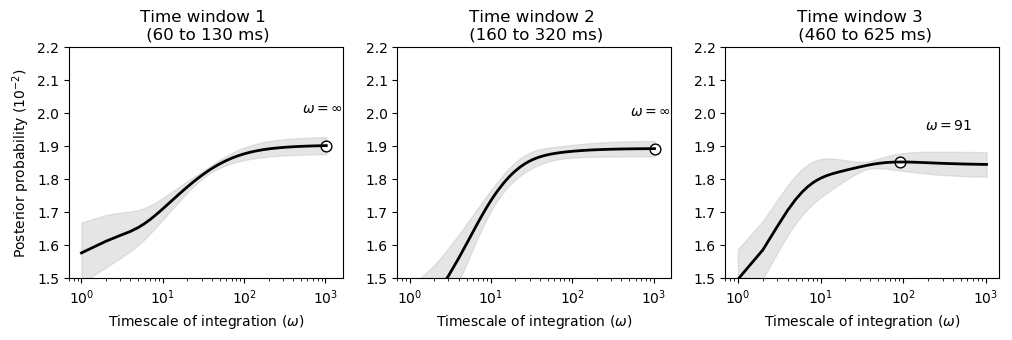

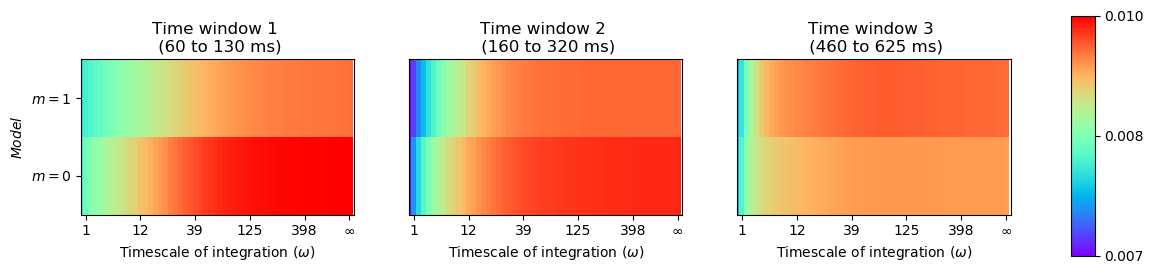

In [49]:
blocks = 4
for block in 1:blocks
    lg("BLOCK $block")
    
    fig = fig5D(mBICsByBlock[block,:,:,:], leaky_models, sliceNames)
    display(fig)
    clf()

    fig = fig5E(ws, pBICsByBlock[block,:,:,:], sliceNames)
    display(fig)
    clf()

    fig = fig5EHeat([ws], leaky_models, pBICsByBlock[block,:,:,:], sliceNames)
    display(fig)
    clf()
end

## By block for inference and no inference

In [20]:
window_lengths = [0,1,2,3,4]

#############
#### LEAKY
#############
ws = vcat(log2range(0, 10, 54), [Inf])

# leak prior
leaky_models_full = map(
    m -> map(
        w -> Leaky(w, prior_uniform(m), leakprior=true, updateallcols=true),
        ws
    ),
    window_lengths[2:end] # ignore m = 0
)
leaky_models_full = vcat(leaky_models_full...)

# don't leak prior
leaky_models_partial = map(
    m -> map(
        w -> Leaky(w, prior_uniform(m), leakprior=false, updateallcols=true),
        ws
    ),
    window_lengths[2:end] # ignore m = 0
)
leaky_models_partial = vcat(leaky_models_partial...)

# no inference
leaky_models_noinference = map(
    m -> map(
        w -> Leaky(w, prior_fixed(m), leakprior=false, updateallcols=true),
        ws
    ),
    window_lengths
)
leaky_models_noinference = vcat(leaky_models_noinference...)


# particle filtering
nparticles = 100
nthreshold = Int(nparticles / 2)

pcs = 1 .- exp.(- 1 ./ ws)
ms = pcs ./ (1 .- pcs)

par_models = map(
    wl -> map(
        m -> ParticleFiltering(m, nparticles, nthreshold, prior_uniform(wl)),
        ms
    ),
    window_lengths[2:end] # ignore m = 0
)
par_models = vcat(par_models...)

par_models_noinference = map(
    wl -> map(
        m -> ParticleFiltering(m, nparticles, nthreshold, prior_fixed(wl)),
        ms
    ),
    window_lengths
)
par_models_noinference = vcat(par_models_noinference...)

# models
models = [leaky_models_full, leaky_models_partial, leaky_models_noinference,
          par_models, par_models_noinference]

# slices
slices, slicenames = buildslices()

# subjects
subjects = 1:18

# keep block level
onehotencode_blocks = true;

In [ ]:
dir = "rss_block"
normalize_meg = false
verbose = 2

pBICs, mBICs = getsubjectsBICblock(subjects, models, slices,
    onehotencode_blocks, normalize_meg, dir, verbose);

[2020-06-08T19:53:30.283] getsubjectsBIC: Loading data for subject 1...
[2020-06-08T19:53:38.465] mapBICblock: computing RSS...
[2020-06-08T19:53:38.467] mapsubject: decoding sequence for all models
[2020-06-08T20:01:13.947] mapRSSblock: computing RSS...
